# SIT744 Assignment 2: Efficient Training of Convolutional Neural Network 

Name: Linh Tran

ID: 218609476

## Assignment objective

This assignment is to feedback on your learning in deep learning theory and its application to  data analytics or artificial intelligence problems.  

It builds on Assignment 1 but requires a higher level of mastery of deep learning theory and programming/engineering skills. In particular, you will experience training a much deeper network on a large-scale dataset. You will encounter  practical issues that help you consolidate textbook learning. 

## Task 1 Solving Fashion-MNIST with Convolutional Neural Networks

*(weight ~20%)*

In Assignment 1, you tackled the image classification problem in Fashion-MNIST. There, you used a Densely Connected Neural Network. You should now know that is not an optimal model architecture for the problem. In Assignment 2, you will apply the best practices of deep-learning computer vision to improve the image classification performance.

####Setting up

In [2]:
%tensorflow_version 2.x
# TensorFlow and tf.keras
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.regularizers import l1, l2

# Helper libraries
from tensorflow.keras.applications import VGG16, VGG19
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


### Task 1.1 Revisit Fashion-MNIST classification with DNN

*(weight ~3%)*

Review your Assignment 1 solution, and reproduce the experiment here. Try to improve the model without changing the model architecture.


####Load dataset and construce pipelines

In [8]:
#load the dataset into train and test
train, test = tf.keras.datasets.fashion_mnist.load_data()

#split train, validation sets
x, y = train
x_test, y_test = test

#process train sets
x = x.reshape(60000, 28 * 28).astype('float32')/255
y = to_categorical(y)

#process test set
x_test = x_test.reshape(10000, 28 * 28).astype('float32')/255
y_test = to_categorical(y_test)

#split train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

print("x_train.shape:", x_train.shape, ", y_train.shape:", y_train.shape)
print("x_valid.shape:", x_valid.shape, ", y_valid.shape:", y_valid.shape)
print("x_test.shape:", x_test.shape, ", y_test.shape:", y_test.shape)

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
valid_batches = valid_set.batch(batch_size)
test_batches = test_set.batch(batch_size)

x_train.shape: (48000, 784) , y_train.shape: (48000, 10)
x_valid.shape: (12000, 784) , y_valid.shape: (12000, 10)
x_test.shape: (10000, 784) , y_test.shape: (10000, 10)


####An experiment with decay rate

In this part, I will reconstruct the model that I built in Assignment 1. In order to improve the the model without changing the architecture, I will run an experiment with the time-based learning rate decay that is a built-in option inside optimizer SGD. Last time, I used decay = 2e-6. This time, I will try out 2 scenarios one with decay = 1e-3 and one with decay = 2e-6 to compare the outcomes and determine which decay rate better promotes model training. I still keep the same momentum = 0.9 and learning rate = 0.01 as I used in assignment 1.

In [3]:
# reconstruct model from Assignment 1 and run experiment:
def a1_model(para):
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', kernel_initializer=initializers.he_uniform(seed=0), input_shape = (28*28,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(64, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))

  optimizer = keras.optimizers.SGD(lr=para[0], momentum=para[1], decay=para[2], nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

lrs = [0.01]
momentums = [0.9]
decays = [1e-3, 2e-6]
combi = [[a,b,c] for a in lrs for b in momentums for c in decays]

test_results = []
histories = []
for x in combi:
  model = a1_model(x)
  history = model.fit(
      train_batches,
      epochs=100,
      validation_data=valid_batches,
      verbose = 0)
  test_loss, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Learning rate: {}, Momentum: {}, Decay: {}, test accuracy: {}'.format(x[0], x[1], x[2], test_acc))
  test_results.append(test_acc)
  histories.append(history)

Learning rate: 0.01, Momentum: 0.9, Decay: 0.001, test accuracy: 0.8824999928474426
Learning rate: 0.01, Momentum: 0.9, Decay: 2e-06, test accuracy: 0.8921999931335449


Higher test accuracy with Decay: 2e-06, test accuracy: 0.8921999931335449
Lower test accuracy with Decay: 0.001, test accuracy: 0.8824999928474426


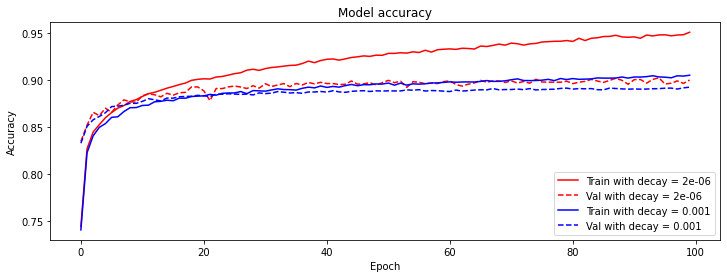

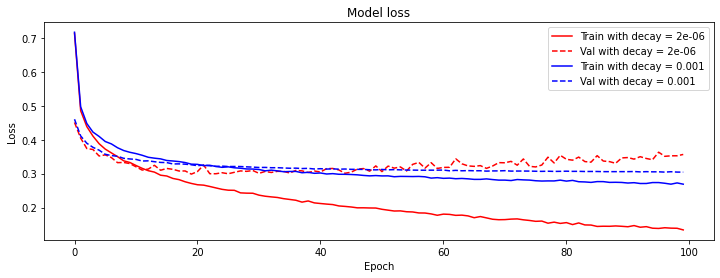

In [4]:
# Parameter values at which test accuracy is higher
better_acc = np.argmax(test_results)
better_combi = combi[better_acc]
worse_acc = np.argmin(test_results)
worse_combi = combi[worse_acc]

print("Higher test accuracy with Decay: {}, test accuracy: {}".format(better_combi[2], test_results[better_acc]))
print("Lower test accuracy with Decay: {}, test accuracy: {}".format(worse_combi[2], test_results[worse_acc]))

history1 = histories[better_acc]
history0 = histories[worse_acc]

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(history1.history['categorical_accuracy'],'r', label = 'Train with decay = {}'.format(better_combi[2]))
plt.plot(history1.history['val_categorical_accuracy'],'r--', label = 'Val with decay = {}'.format(better_combi[2]))
plt.plot(history0.history['categorical_accuracy'],'b', label = 'Train with decay = {}'.format(worse_combi[2]))
plt.plot(history0.history['val_categorical_accuracy'],'b--', label = 'Val with decay = {}'.format(worse_combi[2]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(history1.history['loss'], 'r', label = 'Train with decay = {}'.format(better_combi[2]))
plt.plot(history1.history['val_loss'], 'r--', label = 'Val with decay = {}'.format(better_combi[2]))
plt.plot(history0.history['loss'], 'b', label = 'Train with decay = {}'.format(worse_combi[2]))
plt.plot(history0.history['val_loss'], 'b--', label = 'Val with decay = {}'.format(worse_combi[2]))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the results, we can see the test accuracy of model with decay = 2e-6 is 1% better than that with decay = 1e-3 (89.2% compared with 88.2%). However, model with decay = 2e-6 gets overfitted training after 20 epochs. In terms of generalization, the latter model with decay = 1e-3 turns out to be more robust. In the next section, I will use time-based learning decay = 1e-3 inside SGD optimiser to compile model.

### Task 1.2 Train a ConvNet from scratch

*(weight ~5%)*

Build a ConvNet to replace the densely connected network in Task 1.1. Report the classification accuracy on the test set. Aim to achieve higher accuracy. 



####Reload dataset, preprocess and construct pipelines

Since in ConvNet, we do not need to flatten input data before training, I only reshape the images into 3 dimension with the last dimension being the number of image channel. Fashion-MNIST images are grayscale images therefore the number of channel is 1. After that, I convert the data type into 'float32' then normalize the images by dividing input data with 255.

In [9]:
#reload the dataset into train and test
train, test = tf.keras.datasets.fashion_mnist.load_data()

#split train, validation sets
x, y = train
x_test, y_test = test

#process train and validation sets
x = x.reshape(60000, 28, 28, 1).astype('float32')/255
y = to_categorical(y)

#process test set
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32')/255
y_test = to_categorical(y_test)

#split train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

print("x_train.shape:", x_train.shape, ", y_train.shape:", y_train.shape)
print("x_valid.shape:", x_valid.shape, ", y_valid.shape:", y_valid.shape)
print("x_test.shape:", x_test.shape, ", y_test.shape:", y_test.shape)

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
valid_batches = valid_set.batch(batch_size)
test_batches = test_set.batch(batch_size)

x_train.shape: (48000, 28, 28, 1) , y_train.shape: (48000, 10)
x_valid.shape: (12000, 28, 28, 1) , y_valid.shape: (12000, 10)
x_test.shape: (10000, 28, 28, 1) , y_test.shape: (10000, 10)


####ConvNet Baseline model construction

In this section, I will do experiments with models of 1-2-3 convolutional blocks respectively. In each type, I tried out different number of filters in each block, then compare test accuracy produced by these models to determine the best number of blocks and the number of filters for each layer to construct the Conv Baseline model.

#####Models with 1 conv block

In [0]:
def model_1b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[1], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden = [32, 64, 128]
dense = [256, 512, 1024]
para_1b = [[a,b] for a in hidden for b in dense]

results_1b = []
histories_1b = []
for x in para_1b:
  model = model_1b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}, dense: {}, test accuracy: {}'.format(x[0], x[1], test_acc))
  results_1b.append(test_acc)
  histories_1b.append(history)

  # Para at which test acc is highest
best_acc_1b = np.argmax(results_1b)
best_para_1b = para_1b[best_acc_1b]
print("Best model with 1 block: Conv2D {}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_1b[0],best_para_1b[1], results_1b[best_acc_1b]))

Conv2D: 32, dense: 256, test accuracy: 0.9067000150680542
Conv2D: 32, dense: 512, test accuracy: 0.9100000262260437
Conv2D: 32, dense: 1024, test accuracy: 0.9118000268936157
Conv2D: 64, dense: 256, test accuracy: 0.9118000268936157
Conv2D: 64, dense: 512, test accuracy: 0.9140999913215637
Conv2D: 64, dense: 1024, test accuracy: 0.9142000079154968
Conv2D: 128, dense: 256, test accuracy: 0.9104999899864197
Conv2D: 128, dense: 512, test accuracy: 0.9107999801635742
Conv2D: 128, dense: 1024, test accuracy: 0.9144999980926514
Best model with 1 block: Conv2D 128, dense: 1024, Test accuracy for 20 epochs: 0.9144999980926514


Experiments show that model with 1 Convolutional block of 128 filters and 1 Dense layer of 1024 nodes produces the highest test accuracy 91.49% among models with 1 block. I train this model for 200 epochs, test accuracy of model after 200 epochs training is 92.07%

In [0]:
# Reload and run the best model for 200 epochs
best_model_1b = model_1b(best_para_1b)
best_history_1b = best_model_1b.fit(train_batches, epochs=200, validation_data=valid_batches)
_, best_test_acc_1b = best_model_1b.evaluate(test_batches, verbose = 0)
print('Best model with 1 block: Conv2D {}, dense: {}, Test accuracy for 200 epochs: {}'.format(best_para_1b[0], best_para_1b[1], best_test_acc_1b))

Epoch 1/200
750/750 [==============================] - 6s 7ms/step - loss: 0.4696 - categorical_accuracy: 0.8431 - val_loss: 0.3237 - val_categorical_accuracy: 0.8901
Epoch 2/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2945 - categorical_accuracy: 0.8949 - val_loss: 0.2884 - val_categorical_accuracy: 0.8982
Epoch 3/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2539 - categorical_accuracy: 0.9091 - val_loss: 0.2712 - val_categorical_accuracy: 0.9060
Epoch 4/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2298 - categorical_accuracy: 0.9175 - val_loss: 0.2544 - val_categorical_accuracy: 0.9118
Epoch 5/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2118 - categorical_accuracy: 0.9239 - val_loss: 0.2507 - val_categorical_accuracy: 0.9129
Epoch 6/200
750/750 [==============================] - 5s 7ms/step - loss: 0.1970 - categorical_accuracy: 0.9297 - val_loss: 0.2412 - val_categorical_accuracy: 0.914

#####Models with 2 conv blocks

In [0]:
def model_2b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[1], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[2], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden1 = [32, 64]
hidden2 = [128, 256]
dense = [512, 1024]
para_2b = [[a,b,c] for a in hidden1 for b in hidden2 for c in dense]

results_2b = []
histories_2b = []
for x in para_2b:
  model = model_2b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}-{}, dense: {}, test accuracy: {}'.format(x[0], x[1], x[2], test_acc))
  results_2b.append(test_acc)
  histories_2b.append(history)

  # Para at which test acc is highest
best_acc_2b = np.argmax(results_2b)
best_para_2b = para_2b[best_acc_2b]
print("Best model with 2 blocks: Conv2D {}-{}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_2b[0],best_para_2b[1],best_para_2b[2], results_2b[best_acc_2b]))

Conv2D: 32-128, dense: 512, test accuracy: 0.904699981212616
Conv2D: 32-128, dense: 1024, test accuracy: 0.9061999917030334
Conv2D: 32-256, dense: 512, test accuracy: 0.909500002861023
Conv2D: 32-256, dense: 1024, test accuracy: 0.9071000218391418
Conv2D: 64-128, dense: 512, test accuracy: 0.9099000096321106
Conv2D: 64-128, dense: 1024, test accuracy: 0.9075000286102295
Conv2D: 64-256, dense: 512, test accuracy: 0.9110000133514404
Conv2D: 64-256, dense: 1024, test accuracy: 0.9132999777793884
Best model with 2 blocks: Conv2D 64-256, dense: 1024, Test accuracy for 20 epochs: 0.9132999777793884


Experiments show that model with 2 Convolutional blocks of 64 and 256 filters respectively and 1 Dense layer of 1024 nodes produces the highest test accuracy 91.33% among models with 2 blocks. I train this model for 200 epochs, test accuracy after 200 epochs is 91.38%.

In [0]:
# Reload and run the best model for 200 epochs
best_model_2b = model_2b(best_para_2b)
best_history_2b = best_model_2b.fit(train_batches, epochs=200, validation_data=valid_batches)
_, best_test_acc_2b = best_model_2b.evaluate(test_batches, verbose = 0)
print('Best model with 2 blocks: Conv2D {}-{}, dense: {}, Test accuracy for 200 epochs: {}'.format(best_para_2b[0], best_para_2b[1], best_para_2b[2], best_test_acc_2b))

Epoch 1/200
750/750 [==============================] - 5s 6ms/step - loss: 0.4613 - categorical_accuracy: 0.8375 - val_loss: 0.3419 - val_categorical_accuracy: 0.8776
Epoch 2/200
750/750 [==============================] - 5s 6ms/step - loss: 0.3094 - categorical_accuracy: 0.8894 - val_loss: 0.3007 - val_categorical_accuracy: 0.8920
Epoch 3/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2682 - categorical_accuracy: 0.9038 - val_loss: 0.2794 - val_categorical_accuracy: 0.9000
Epoch 4/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2414 - categorical_accuracy: 0.9127 - val_loss: 0.2644 - val_categorical_accuracy: 0.9069
Epoch 5/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2231 - categorical_accuracy: 0.9196 - val_loss: 0.2640 - val_categorical_accuracy: 0.9062
Epoch 6/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2092 - categorical_accuracy: 0.9247 - val_loss: 0.2644 - val_categorical_accuracy: 0.907

#####Models with 3 conv blocks

In [0]:
def model_3b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[1], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[2], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[3], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden1 = [32, 64]
hidden2 = [64, 128]
hidden3 = [128, 256]
dense = [512, 1024]
para_3b = [[a,b,c,d] for a in hidden1 for b in hidden2 for c in hidden3 for d in dense]

results_3b = []
histories_3b = []
for x in para_3b:
  model = model_3b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}-{}-{}, dense: {}, test accuracy: {}'.format(x[0], x[1], x[2], x[3], test_acc))
  results_3b.append(test_acc)
  histories_3b.append(history)

  # Para at which test acc is highest
best_acc_3b = np.argmax(results_3b)
best_para_3b = para_3b[best_acc_3b]
print("Best model with 3 blocks: Conv2D {}-{}-{}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_3b[0],best_para_3b[1],best_para_3b[2],best_para_3b[3], results_3b[best_acc_3b]))

Conv2D: 32-64-128, dense: 512, test accuracy: 0.8823999762535095
Conv2D: 32-64-128, dense: 1024, test accuracy: 0.8844000101089478
Conv2D: 32-64-256, dense: 512, test accuracy: 0.8845999836921692
Conv2D: 32-64-256, dense: 1024, test accuracy: 0.8844000101089478
Conv2D: 32-128-128, dense: 512, test accuracy: 0.8912000060081482
Conv2D: 32-128-128, dense: 1024, test accuracy: 0.8844000101089478
Conv2D: 32-128-256, dense: 512, test accuracy: 0.8853999972343445
Conv2D: 32-128-256, dense: 1024, test accuracy: 0.8888000249862671
Conv2D: 64-64-128, dense: 512, test accuracy: 0.8873999714851379
Conv2D: 64-64-128, dense: 1024, test accuracy: 0.8805999755859375
Conv2D: 64-64-256, dense: 512, test accuracy: 0.8889999985694885
Conv2D: 64-64-256, dense: 1024, test accuracy: 0.887499988079071
Conv2D: 64-128-128, dense: 512, test accuracy: 0.8924999833106995
Conv2D: 64-128-128, dense: 1024, test accuracy: 0.890500009059906
Conv2D: 64-128-256, dense: 512, test accuracy: 0.8902000188827515
Conv2D: 64-12

Apparently, models with 3 Convolutional blocks train data the worst compared to those with 1 and 2 blocks. Hence, I will not run the best model with 3 blocks for more epochs. Next section, I will only compare training performance between best models with 1 and 2 blocks.

#####Comparison

Below are plots and test accuracy of the best models with 1 and 2 blocks respectively:

Best model with 1 blocks: Conv2D 128, dense: 1024, Test accuracy for 200 epochs: 0.9207000136375427
Best model with 2 blocks: Conv2D 64-256, dense: 1024, Test accuracy for 200 epochs: 0.9138000011444092


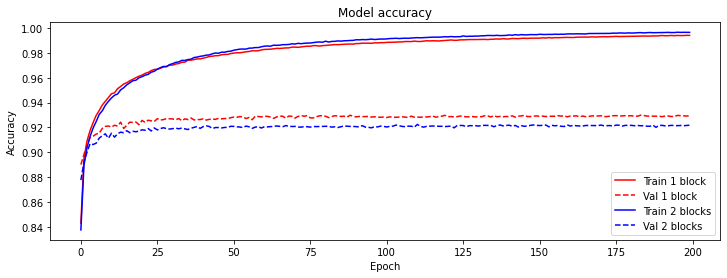

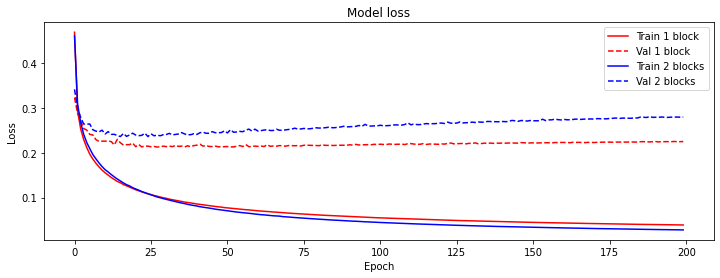

In [0]:
# Test accuracy
print('Best model with 1 block: Conv2D {}, dense: {}, Test accuracy for 200 epochs: {}'.format(best_para_1b[0],best_para_1b[1], best_test_acc_1b))
print('Best model with 2 blocks: Conv2D {}-{}, dense: {}, Test accuracy for 200 epochs: {}'.format(best_para_2b[0], best_para_2b[1], best_para_2b[2], best_test_acc_2b))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'r', label = 'Train 1 block')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'r--', label = 'Val 1 block')
plt.plot(best_history_2b.history['categorical_accuracy'],'b', label = 'Train 2 blocks')
plt.plot(best_history_2b.history['val_categorical_accuracy'],'b--', label = 'Val 2 blocks')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'r', label = 'Train 1 block')
plt.plot(best_history_1b.history['val_loss'], 'r--', label = 'Val 1 block')
plt.plot(best_history_2b.history['loss'], 'b', label = 'Train 2 blocks')
plt.plot(best_history_2b.history['val_loss'], 'b--', label = 'Val 2 blocks')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the training result after 200 epochs, the best model with 1 block turns out to have better training performance on the dataset in terms of both optimization capacity (lower loss) and generalization (less overfit). Therefore, in the next parts, I will use model with 1 block having 1 Conv2D layer of 128 nodes and 1 Dense layer of 1024 nodes as baseline model for upcoming comparisons. 





#####ConvNet Baseline model architecture

This is how our Baseline Convnet model architecture will look like:

In [0]:
def model_1b():
  model = models.Sequential()
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

baseline_model = model_1b()
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              22152192  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total params: 22,163,722
Trainable params: 22,163,722
Non-trainable params: 0
_________________________________________________________________


####Add dropout

As can be seen in the above graph, training of the baseline model gets overfitted after around 10 epochs. In order to reduce overfitting, I add dropout layer of 20% into model architecture as follows and run the dropout model for 200 epochs.

In [0]:
# construct baseline model with dropout layers
def drop_model_1b():
  model = models.Sequential()
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

# model with dropout
drop_model_1b = drop_model_1b()
drop_model_1b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              22152192  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [0]:
drop_history_1b = drop_model_1b.fit(train_batches, epochs=200, validation_data=valid_batches)

Epoch 1/200
750/750 [==============================] - 6s 8ms/step - loss: 0.4929 - categorical_accuracy: 0.8298 - val_loss: 0.3341 - val_categorical_accuracy: 0.8794
Epoch 2/200
750/750 [==============================] - 6s 8ms/step - loss: 0.3253 - categorical_accuracy: 0.8826 - val_loss: 0.2987 - val_categorical_accuracy: 0.8917
Epoch 3/200
750/750 [==============================] - 6s 8ms/step - loss: 0.2846 - categorical_accuracy: 0.8970 - val_loss: 0.2709 - val_categorical_accuracy: 0.9052
Epoch 4/200
750/750 [==============================] - 6s 8ms/step - loss: 0.2604 - categorical_accuracy: 0.9059 - val_loss: 0.2591 - val_categorical_accuracy: 0.9093
Epoch 5/200
750/750 [==============================] - 6s 8ms/step - loss: 0.2422 - categorical_accuracy: 0.9122 - val_loss: 0.2611 - val_categorical_accuracy: 0.9066
Epoch 6/200
750/750 [==============================] - 6s 8ms/step - loss: 0.2315 - categorical_accuracy: 0.9155 - val_loss: 0.2513 - val_categorical_accuracy: 0.910

#####Comparison

 Let's see the results:

Baseline test accuracy: 0.9207000136375427
Dropout test accuracy: 0.9248999953269958


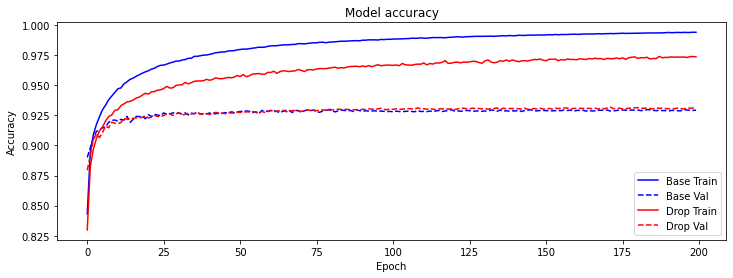

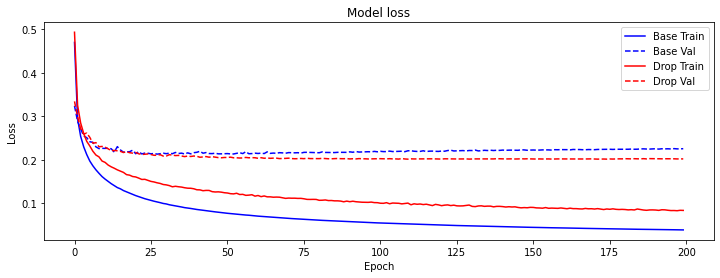

In [0]:
#Test accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
_, drop_test_acc_1b = drop_model_1b.evaluate(test_batches, verbose = 0)
print('Dropout test accuracy: {}'.format(drop_test_acc_1b))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Base Val')
plt.plot(drop_history_1b.history['categorical_accuracy'],'r', label = 'Drop Train')
plt.plot(drop_history_1b.history['val_categorical_accuracy'],'r--', label = 'Drop Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Base Val')
plt.plot(drop_history_1b.history['loss'], 'r', label = 'Drop Train')
plt.plot(drop_history_1b.history['val_loss'], 'r--', label = 'Drop Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the graphs, it is clear that dropout has significantly reduced overfitting and slightly improved test accuracy (from 92.07% we got 92.5%)


### Task 1.3 Build an input pipeline for data augmentation

*(weight ~5%)*

Build a data preprocessing pipeline to perform data augmentation. (You may use Keras ImageDataGenerator or write your own transformations.)

- Report the new classification accuracy. Make sure that you use the same number of training epochs as in Task 1.2.

- (Optional) Profile your input pipeline to identify the most time-consuming operation. What actions have you taken to address that slow operation? (*Hint: You may use the [TensorFlow Profiler](https://github.com/tensorflow/profiler).*)

####Add data augmentation

In order to train model with data augmentation, I will use ImageDataGenerator to transform training data randomly

In [0]:
batch_size = 64

#construct aug train pipeline
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20, zoom_range=0.15,	horizontal_flip=True, fill_mode="nearest")
train_datagen.fit(x_train)
aug_train_batches = train_datagen.flow(x_train, y_train, shuffle = True, batch_size=batch_size)

Here is how newly augmented training images would look like:

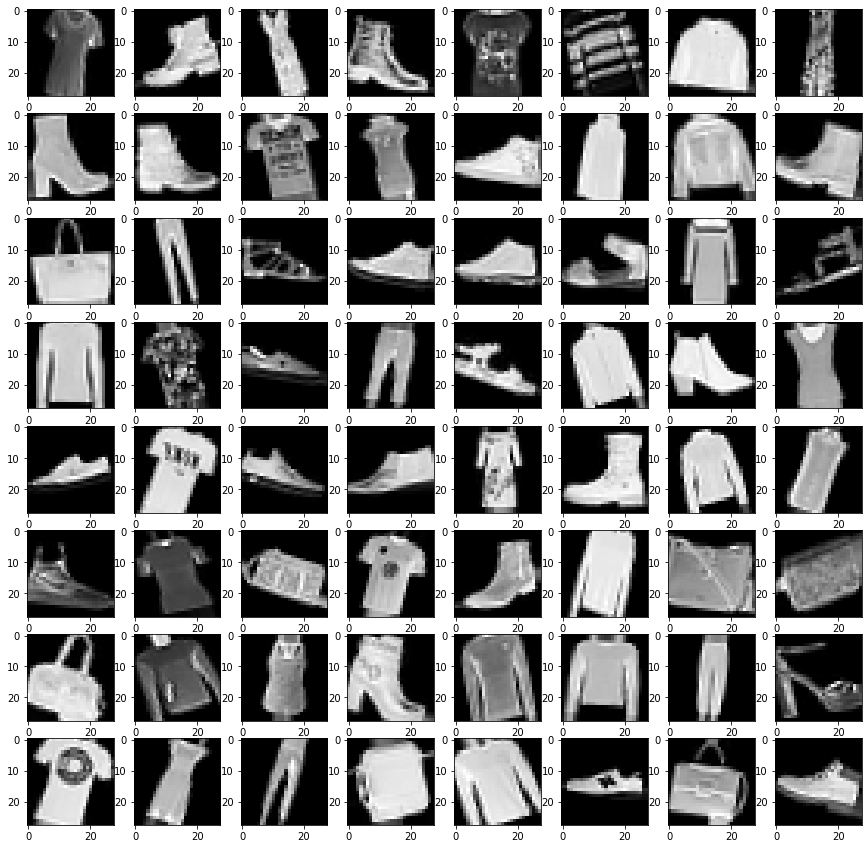

In [0]:
#show augmented images
for x_batch, y_batch in aug_train_batches:
	# create a grid of 3x3 images
  plt.figure(figsize = (15,15))
  for i in range(0, 64):
    plt.subplot(8,8, 1 + i)
    plt.imshow(x_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
  plt.show()
  break

Now I will train the ConvNet Baseline model with augmented data generated by ImageDataGenerator for 200 epochs

In [0]:
# run model with augmented data
aug_model_1b = model_1b()
aug_history_1b = aug_model_1b.fit(
      aug_train_batches,
      steps_per_epoch=100,
      epochs=200,
      validation_data=valid_batches)

Epoch 1/200
100/100 [==============================] - 3s 25ms/step - loss: 0.9652 - categorical_accuracy: 0.6662 - val_loss: 0.6124 - val_categorical_accuracy: 0.7630
Epoch 2/200
100/100 [==============================] - 2s 24ms/step - loss: 0.6653 - categorical_accuracy: 0.7475 - val_loss: 0.6130 - val_categorical_accuracy: 0.7751
Epoch 3/200
100/100 [==============================] - 2s 24ms/step - loss: 0.6205 - categorical_accuracy: 0.7631 - val_loss: 0.6416 - val_categorical_accuracy: 0.7435
Epoch 4/200
100/100 [==============================] - 2s 24ms/step - loss: 0.5773 - categorical_accuracy: 0.7852 - val_loss: 0.5593 - val_categorical_accuracy: 0.7864
Epoch 5/200
100/100 [==============================] - 2s 24ms/step - loss: 0.5659 - categorical_accuracy: 0.7856 - val_loss: 0.5755 - val_categorical_accuracy: 0.7772
Epoch 6/200
100/100 [==============================] - 2s 24ms/step - loss: 0.5490 - categorical_accuracy: 0.8009 - val_loss: 0.4811 - val_categorical_accuracy:

#####Comparison

Baseline test accuracy: 0.9207000136375427
Augmented test accuracy: 0.8901000022888184


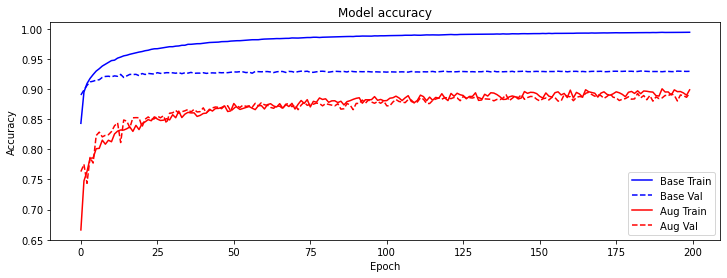

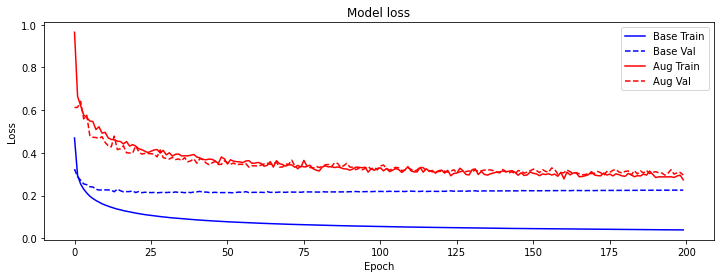

In [0]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
_, aug_test_acc_1b = aug_model_1b.evaluate(test_batches, verbose = 0)
print("Augmented test accuracy: {}".format(aug_test_acc_1b))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Base Val')
plt.plot(aug_history_1b.history['categorical_accuracy'],'r', label = 'Aug Train')
plt.plot(aug_history_1b.history['val_categorical_accuracy'],'r--', label = 'Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Base Val')
plt.plot(aug_history_1b.history['loss'], 'r', label = 'Aug Train')
plt.plot(aug_history_1b.history['val_loss'], 'r--', label = 'Aug Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the graph, we can see that training with data augmentation has completely overcome overfitting; however, model optimization capacity has been reduced as we have lower accuracy and higher loss. The model also produces less accurate predictions on test set compared to the baseline model (89% accuracy on test set compared to 92%)

####Add dropout and augmented data

In this part, I will combine 2 regularization techniques which are dropout and augmentation together. Below are the results:

In [0]:
# run model with both dropout layers and augmented data
drop_aug_model_1b = drop_model_1b()
drop_aug_history_1b = drop_aug_model_1b.fit(
      aug_train_batches,
      steps_per_epoch=100,
      epochs=200,
      validation_data=valid_batches)

Epoch 1/200
100/100 [==============================] - 3s 25ms/step - loss: 1.1222 - categorical_accuracy: 0.6275 - val_loss: 0.6183 - val_categorical_accuracy: 0.7641
Epoch 2/200
100/100 [==============================] - 2s 24ms/step - loss: 0.7344 - categorical_accuracy: 0.7264 - val_loss: 0.5512 - val_categorical_accuracy: 0.7903
Epoch 3/200
100/100 [==============================] - 2s 25ms/step - loss: 0.6417 - categorical_accuracy: 0.7534 - val_loss: 0.5298 - val_categorical_accuracy: 0.7993
Epoch 4/200
100/100 [==============================] - 2s 24ms/step - loss: 0.6142 - categorical_accuracy: 0.7686 - val_loss: 0.5242 - val_categorical_accuracy: 0.8029
Epoch 5/200
100/100 [==============================] - 2s 24ms/step - loss: 0.6057 - categorical_accuracy: 0.7763 - val_loss: 0.5226 - val_categorical_accuracy: 0.7934
Epoch 6/200
100/100 [==============================] - 2s 24ms/step - loss: 0.5933 - categorical_accuracy: 0.7719 - val_loss: 0.4878 - val_categorical_accuracy:

#####Comparison

Baseline test accuracy: 0.9207000136375427
Dropout test accuracy: 0.9248999953269958
Augmented test accuracy: 0.8901000022888184
Dropout and augmentation test accuracy: 0.8844000101089478


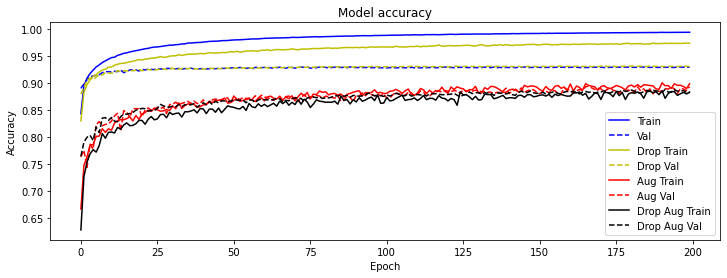

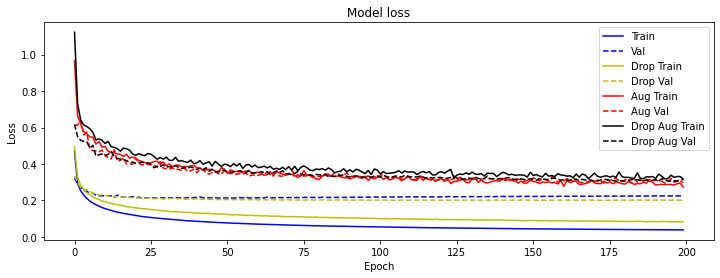

In [0]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
print('Dropout test accuracy: {}'.format(drop_test_acc_1b))
print("Augmented test accuracy: {}".format(aug_test_acc_1b))
_, drop_aug_test_acc_1b = drop_aug_model.evaluate(test_batches, verbose = 0)
print('Dropout and augmentation test accuracy: {}'.format(drop_aug_test_acc_1b))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Val')
plt.plot(drop_history_1b.history['categorical_accuracy'],'y', label = 'Drop Train')
plt.plot(drop_history_1b.history['val_categorical_accuracy'],'y--', label = 'Drop Val')
plt.plot(aug_history_1b.history['categorical_accuracy'],'r', label = 'Aug Train')
plt.plot(aug_history_1b.history['val_categorical_accuracy'],'r--', label = 'Aug Val')
plt.plot(drop_aug_history_1b.history['categorical_accuracy'],'k', label = 'Drop Aug Train')
plt.plot(drop_aug_history_1b.history['val_categorical_accuracy'],'k--', label = 'Drop Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Val')
plt.plot(drop_history_1b.history['loss'], 'y', label = 'Drop Train')
plt.plot(drop_history_1b.history['val_loss'], 'y--', label = 'Drop Val')
plt.plot(aug_history_1b.history['loss'], 'r', label = 'Aug Train')
plt.plot(aug_history_1b.history['val_loss'], 'r--', label = 'Aug Val')
plt.plot(drop_aug_history_1b.history['loss'], 'k', label = 'Drop Aug Train')
plt.plot(drop_aug_history_1b.history['val_loss'], 'k--', label = 'Drop Aug Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Looking at the graph, we can see that the combination of dropout and augmentation has the same effect into training process as augmentation only. This model also eliminates overfitting; however, it reduces training prediction and optimization capacity. Test accuracy is the lowest (88.4%) among 4 models so far. Next section we'll use transfer learning to see whether it improves model performace.

### Task 1.4 Fashion-MNIST with transfer learning

*(weight ~5%)*

Use a pretrained model as the convolutional base to improve the classification performance. (Hint: You may use models in Keras Applications or those in the TensorFlow Hub.)

- Try both with fine-tuning and without fine-tuning.
- Report the model performance as before.



####Reload dataset and construct pipelines toward pre-train model requirements

All pre-trained models available at Keras Applications require input images to have minimum size of 32x32 and exactly 3 channels (Keras, 2020). Since I will use VGG19 as the pretrained model for transfer learning in this section, I reload the dataset and pre-process the data to have size 150x150 and 3 channels then batch them to create data pipelines

In [8]:
#load the dataset into train and test
train, test = tf.keras.datasets.fashion_mnist.load_data()
x, y = train
x_test, y_test = test

# Convert the training and test images into 3 channels
x = x.reshape(60000, 28*28, 1)
x_test = x_test.reshape(10000, 28*28, 1)
x = np.dstack([x] * 3)
x_test = np.dstack([x_test]*3)

#reshape and normalize
x = x.reshape(60000, 28, 28, 3).astype('float32')/255
y = to_categorical(y)
x_test = x_test.reshape(10000, 28, 28, 3).astype('float32')/255
y_test = to_categorical(y_test)

#split train, validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# function to resize images into size 150x150
def pre_process_image(image, label):
  image = tf.image.resize(image, (150, 150))
  return image, label

# batch the sets according to batch_size
batch_size = 64
train_batches = train_set.map(pre_process_image).shuffle(buffer_size=1024).batch(batch_size).cache().repeat()
valid_batches = valid_set.map(pre_process_image).batch(batch_size).cache().repeat()
test_batches = test_set.map(pre_process_image).batch(batch_size)

# check the image size in batch data
xtrain_batch, ytrain_batch = next(iter(train_batches))
xvalid_batch, yvalid_batch = next(iter(valid_batches))
xtest_batch, ytest_batch = next(iter(test_batches))

print("xtrain_batch_size:", xtrain_batch.shape[1:])
print("xvalid_batch_size:", xvalid_batch.shape[1:])
print("xtest_batch_size:", xtest_batch.shape[1:])

xtrain_batch_size: (150, 150, 3)
xvalid_batch_size: (150, 150, 3)
xtest_batch_size: (150, 150, 3)


####Fixed Pre-trained Conv-base model

As mentioned earlier, I would choose VGG19 as the pretrained model for transfer learning:

In [9]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3),
                  classes = 10)
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#####An experiment with the number of nodes

In this section, similar to the above-conducted experiment, I will tried out different numbers of nodes to determine the best number of nodes in the Dense layer of our modified model. In the convolutional base, I set the weights not to be trainable, meaning that during training, these weight in the convolutional base will not be updated.

In [11]:
def pretrn_model(dense):
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(dense, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)
  loss = keras.losses.CategoricalCrossentropy(from_logits=False)
  metrics = keras.metrics.CategoricalAccuracy()
  
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
#try out 3 different numbers of dense nodes
denses = [256, 512, 1024]
results = []

for dense in denses:
  conv_base.trainable = False
  model = pretrn_model(dense)
  history = model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=20,
      validation_data=valid_batches,
      validation_steps=10,
      verbose = 0)
  test_loss, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Dense: {}, test accuracy: {}'.format(dense, test_acc))
  results.append(test_acc)

# Parameter values at which test acc is highest
acc_best = np.argmax(results)
best_dense = denses[acc_best]
print("Best model with dense layer = {}, Test accuracy for 20 epochs: {}".format(best_dense, results[acc_best]))

Dense: 256, test accuracy: 0.8776999711990356
Dense: 512, test accuracy: 0.8751000165939331
Dense: 1024, test accuracy: 0.8752999901771545
Best model with dense layer = 256, Test accuracy for 20 epochs: 0.8776999711990356


Results after training each model for 20 epochs show that a Dense layer of 256 nodes produces higher test accuracy than the other 2 options. Test accuracy produced by three models are:

- Dense: 256, test accuracy: 0.8776999711990356

- Dense: 512, test accuracy: 0.8751000165939331

- Dense: 1024, test accuracy: 0.8752999901771545

I will choose 256 as the number of nodes for my modified model below.


#####Fixed Pre-trained Conv-base model architecture

Below is how our model with fixed pretrained conv base and a dense layer of 256 nodes will look like. I will train this model for 200 epochs then compare it with our baseline model above:

In [12]:
def pretrn_model():
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)
  loss = keras.losses.CategoricalCrossentropy(from_logits=False)
  metrics = keras.metrics.CategoricalAccuracy()
  
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

conv_base.trainable = False
pretrn_model = pretrn_model()
pretrn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                2570      
Total params: 22,124,362
Trainable params: 2,099,978
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
pretrn_history = pretrn_model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=200,
      validation_data=valid_batches,
      validation_steps=10)

Epoch 1/200
100/100 [==============================] - 10s 99ms/step - loss: 1.0975 - categorical_accuracy: 0.6342 - val_loss: 0.5684 - val_categorical_accuracy: 0.7688
Epoch 2/200
100/100 [==============================] - 10s 97ms/step - loss: 0.5462 - categorical_accuracy: 0.7989 - val_loss: 0.4484 - val_categorical_accuracy: 0.8344
Epoch 3/200
100/100 [==============================] - 10s 97ms/step - loss: 0.4713 - categorical_accuracy: 0.8206 - val_loss: 0.3768 - val_categorical_accuracy: 0.8562
Epoch 4/200
100/100 [==============================] - 10s 97ms/step - loss: 0.4167 - categorical_accuracy: 0.8530 - val_loss: 0.3381 - val_categorical_accuracy: 0.8828
Epoch 5/200
100/100 [==============================] - 10s 97ms/step - loss: 0.4134 - categorical_accuracy: 0.8495 - val_loss: 0.3269 - val_categorical_accuracy: 0.8844
Epoch 6/200
100/100 [==============================] - 10s 97ms/step - loss: 0.3903 - categorical_accuracy: 0.8577 - val_loss: 0.3249 - val_categorical_acc

#####Comparison

Baseline test accuracy: 0.9207000136375427
Pre-train with fixed conv base test accuracy: 0.910937488079071


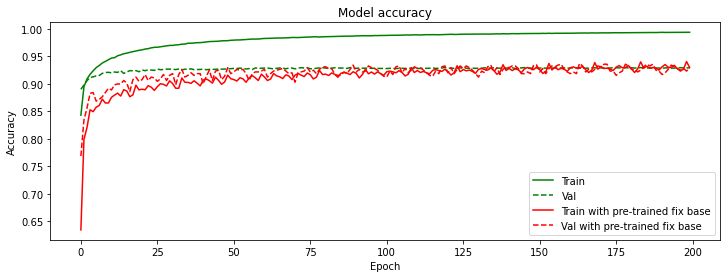

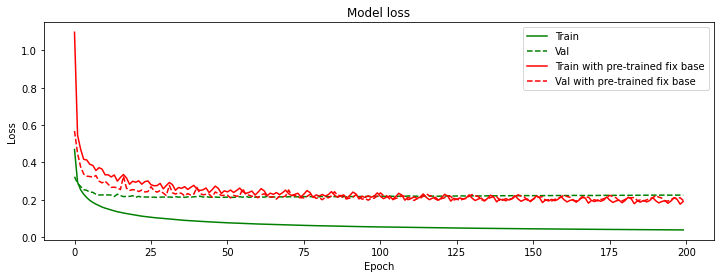

In [0]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
pretrn_test_loss, pretrn_test_acc = pretrn_model.evaluate(test_batches, verbose = 0)
print("Pre-train with fixed conv base test accuracy: {}".format(pretrn_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'g', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'g--', label = 'Base Val')
plt.plot(pretrn_history.history['categorical_accuracy'],'r', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_categorical_accuracy'],'r--', label = 'Fixed Conv Base Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'g', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'g--', label = 'Base Val')
plt.plot(pretrn_history.history['loss'], 'r', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_loss'], 'r--', label = 'Fixed Conv Base Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

The Fixed Pre-trained Conv-base model is obviously more robust and efficient than our baseline model. Although test accuracy is slightly lower (91.09% compared to 92.07%), its optimization and especially generalization capacity are both more impactful since there is no sign of overfitting.

####Fine-tuned model

Now, I am going to fine tune the pretrained model by setting the last block in VGG19 conv base into trainable. This means that during training the weights in the last block of the convolutional base will be updated. Then I will run the model for 200 epochs and compare the results:

In [0]:
# reload pretrained model and define tuning model
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3),
                  classes = 10)

def tuning_model():
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)
  loss = keras.losses.CategoricalCrossentropy(from_logits=False)
  metrics = keras.metrics.CategoricalAccuracy()
  
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
# run the pretrained model with last layer trainable and one dense layer on top
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

tuning_model = tuning_model(best_dense)
tuning_model.summary()

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_93 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_202 (Dense)            (None, 256)               2097408   
_________________________________________________________________
dense_203 (Dense)            (None, 10)                2570      
Total params: 22,124,362
Trainable params: 11,539,210
Non-trainable params: 10,585,152
_________________________________________________________________


In [0]:
tuning_history = tuning_model.fit(
       train_batches,
       steps_per_epoch=100,
       epochs=200,
       validation_data=valid_batches,
       validation_steps=10)

Epoch 1/200
100/100 [==============================] - 11s 114ms/step - loss: 0.8726 - categorical_accuracy: 0.6948 - val_loss: 0.3502 - val_categorical_accuracy: 0.8562
Epoch 2/200
100/100 [==============================] - 11s 112ms/step - loss: 0.3895 - categorical_accuracy: 0.8572 - val_loss: 0.3101 - val_categorical_accuracy: 0.8813
Epoch 3/200
100/100 [==============================] - 11s 112ms/step - loss: 0.3218 - categorical_accuracy: 0.8791 - val_loss: 0.2490 - val_categorical_accuracy: 0.9062
Epoch 4/200
100/100 [==============================] - 11s 112ms/step - loss: 0.2793 - categorical_accuracy: 0.8997 - val_loss: 0.2246 - val_categorical_accuracy: 0.9203
Epoch 5/200
100/100 [==============================] - 11s 112ms/step - loss: 0.2745 - categorical_accuracy: 0.8980 - val_loss: 0.2184 - val_categorical_accuracy: 0.9141
Epoch 6/200
100/100 [==============================] - 11s 112ms/step - loss: 0.2552 - categorical_accuracy: 0.9080 - val_loss: 0.2255 - val_categoric

#####Comparison

Baseline test accuracy: 0.9207000136375427
Pre-train with fixed conv base test accuracy: 0.910937488079071
Fine tuning test accuracy: 0.9125000238418579


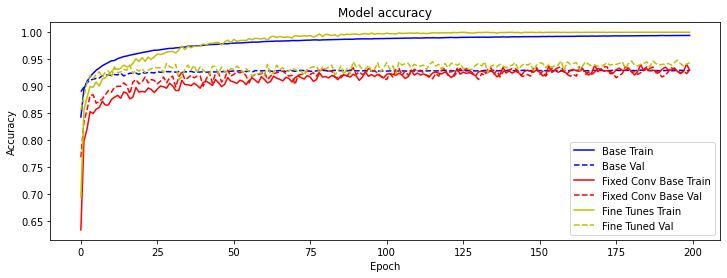

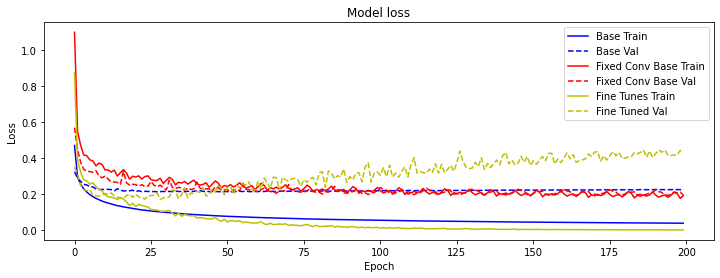

In [0]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
print("Pre-train with fixed conv base test accuracy: {}".format(pretrn_test_acc))
tuning_test_loss, tuning_test_acc = tuning_model.evaluate(test_batches, verbose = 0)
print("Fine tuning test accuracy: {}".format(tuning_test_acc))

# Compare fix conv base vs fine tuning
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Base Val')
plt.plot(pretrn_history.history['categorical_accuracy'],'r', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_categorical_accuracy'],'r--', label = 'Fixed Conv Base Val')
plt.plot(tuning_history.history['categorical_accuracy'],'y', label = 'Fine Tunes Train')
plt.plot(tuning_history.history['val_categorical_accuracy'],'y--', label = 'Fine Tuned Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Base Val')
plt.plot(pretrn_history.history['loss'], 'r', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_loss'], 'r--', label = 'Fixed Conv Base Val')
plt.plot(tuning_history.history['loss'], 'y', label = 'Fine Tunes Train')
plt.plot(tuning_history.history['val_loss'], 'y--', label = 'Fine Tuned Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the graphs, we can see that although its training and validation accuracy trends are both increasing, the fine tuned training gets overfitted in terms of loss values after around 15 epochs. Hence, between pretrained models with and without fine tuning, the latter one is more advisable in this case.

### Task 1.5 Performance comparison

*(weight ~2%)*

Record the test accuracy achieved at different training configurations above. Which method achieved the highest accuracy? Why did it work better for this problem?


Now in this part, I will compare all the models we have experimented so far on Fashion MNIST dataset.

Baseline test accuracy: 0.9207000136375427
Dropout test accuracy: 0.9248999953269958
Augmentation test accuracy: 0.8901000022888184
Dropout + Augmentation test accuracy: 0.8844000101089478
Pre-train with fixed conv base test accuracy: 0.910937488079071
Fine tuning test accuracy: 0.9125000238418579


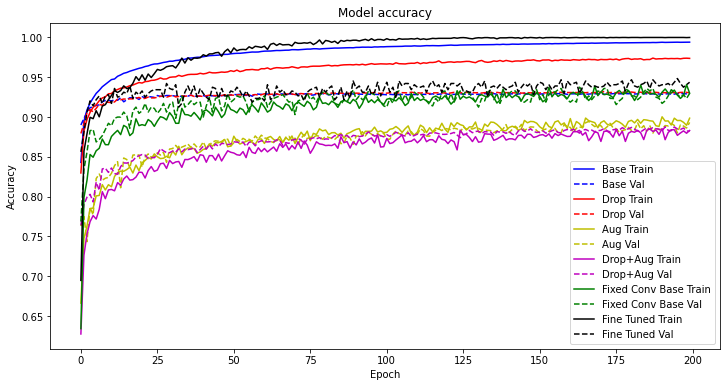

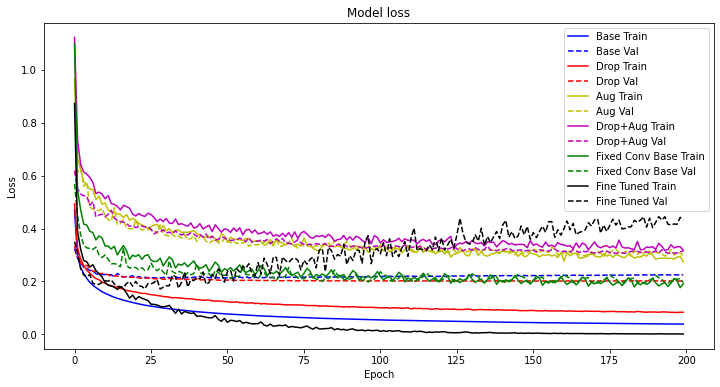

In [0]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
print("Dropout test accuracy: {}".format(drop_test_acc))
print("Augmentation test accuracy: {}".format(aug_test_acc))
print("Dropout + Augmentation test accuracy: {}".format(drop_aug_test_acc))
print("Pre-train with fixed conv base test accuracy: {}".format(pretrn_test_acc))
print("Fine tuning test accuracy: {}".format(tuning_test_acc))

# Compare fix conv base vs fine tuning
plt.figure(figsize = (12,6))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Base Val')
plt.plot(drop_history.history['categorical_accuracy'],'r', label = 'Drop Train')
plt.plot(drop_history.history['val_categorical_accuracy'],'r--', label = 'Drop Val')
plt.plot(aug_history.history['categorical_accuracy'],'y', label = 'Aug Train')
plt.plot(aug_history.history['val_categorical_accuracy'],'y--', label = 'Aug Val')
plt.plot(drop_aug_history.history['categorical_accuracy'],'m', label = 'Drop+Aug Train')
plt.plot(drop_aug_history.history['val_categorical_accuracy'],'m--', label = 'Drop+Aug Val')
plt.plot(pretrn_history.history['categorical_accuracy'],'g', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_categorical_accuracy'],'g--', label = 'Fixed Conv Base Val')
plt.plot(tuning_history.history['categorical_accuracy'],'k', label = 'Fine Tuned Train')
plt.plot(tuning_history.history['val_categorical_accuracy'],'k--', label = 'Fine Tuned Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,6))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Base Val')
plt.plot(drop_history.history['loss'], 'r', label = 'Drop Train')
plt.plot(drop_history.history['val_loss'], 'r--', label = 'Drop Val')
plt.plot(aug_history.history['loss'], 'y', label = 'Aug Train')
plt.plot(aug_history.history['val_loss'], 'y--', label = 'Aug Val')
plt.plot(drop_aug_history.history['loss'], 'm', label = 'Drop+Aug Train')
plt.plot(drop_aug_history.history['val_loss'], 'm--', label = 'Drop+Aug Val')
plt.plot(pretrn_history.history['loss'], 'g', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_loss'], 'g--', label = 'Fixed Conv Base Val')
plt.plot(tuning_history.history['loss'], 'k', label = 'Fine Tuned Train')
plt.plot(tuning_history.history['val_loss'], 'k--', label = 'Fine Tuned Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Better accuracy with Learning rate: 0.01, Momentum: 0.9, Decay: 2e-06, test accuracy: 0.8913999795913696
Worse accuracy with Learning rate: 0.01, Momentum: 0.9, Decay: 0.001, test accuracy: 0.8855999708175659


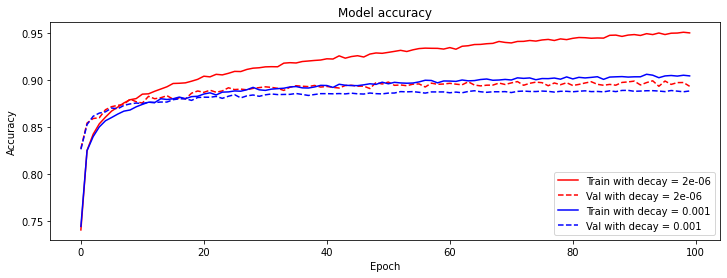

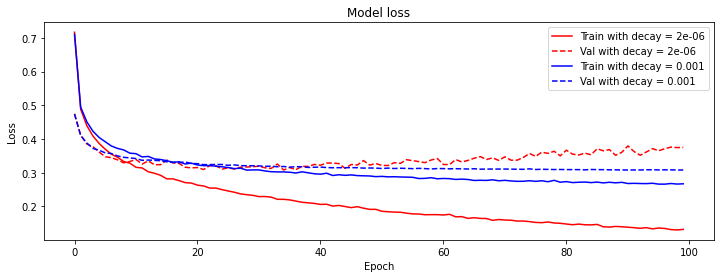

In [0]:
#results of DNN models from previous section

Conclusion:

- As can be seen in the graphs, Convolutional Net models are proved to be more effective and powerful in terms of training performance than Densely Connected Net models

- Among the ConvNet models, the best model would be model with fixed pretrained convolutinal base. Although the test accuracy produced by this model is the third highest among experimented models, it's the most robust model so far with fair optimization and generalization capacity.

- The reason why fixed pretrained convolutional base model works better for this image classification problem is that the VGG19 base was trained on a very large dataset which is the ImageNet dataset (Liu at el, 2015), its set of weights is more powerful since it has been optimized over a wide variety of training images. This pre-trained set of weights then is used for features extraction in our dataset. The features extracted from this convolutional base are efficient so we only need one more Dense layer on top for our model to be specified on our dataset. 

## Task 2 Fast training of deep networks

*(weight ~20%)*

### Task 2.1 Train a highly accurate network for CIFAR10

*(weight ~7%)*

In this task, you will train deep neural networks on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Compared with the datasets that you have worked on so far, CIFAR10 represents a relatively larger multi-class classification problem and presents a great opportunity for you to solve a "harder" problem.



#### Task 2.1.1 Document the hardware used

Before you start, write down your hardware specifications, including 

- the GPU model, the number of GPUs, and the GPU memory
- the CPU model, the number of CPUs, and the CPU clock speed

(Hint: you may find commands like `nvidia-smi`, `lscpu` or `psutil` useful.)

In [0]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-09f82789-4864-1335-0a19-be94a4827bb1)


In [0]:
#GPU memory
!nvidia-smi --format=csv --query-gpu=memory.total
!nvidia-smi --format=csv --query-gpu=memory.used
!nvidia-smi --format=csv --query-gpu=memory.free

memory.total [MiB]
11441 MiB
memory.used [MiB]
130 MiB
memory.free [MiB]
11311 MiB


In [0]:
#GPU activity
!nvidia-smi

Sat May 16 13:53:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    78W / 149W |    130MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#CPU information
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

#### Task 2.1.2 Train a "shallow" ConvNet

Build a ConvNet with fewer than 10 layers. Train the network until it converges. You will use this network as a baseline for the later experiments. 

- Plot the training and validation history. 
- Report the testing accuracy. 

#####Load dataset and preprocessing data

In [3]:
# load dataset
train, test = tf.keras.datasets.cifar10.load_data()
x, y = train
x_test, y_test = test

print('x.shape:', x.shape, ', y.shape:', y.shape)
print('x_test.shape:', x_test.shape, ', y_test.shape:', y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
x.shape: (50000, 32, 32, 3) , y.shape: (50000, 1)
x_test.shape: (10000, 32, 32, 3) , y_test.shape: (10000, 1)


The data from CIFAR10 set has already followed the desired shape, I only need to convert its type into 'float32' and apply normalization before constructing data pipelines.

In [0]:
#split train, validation sets
x, y = train
x_test, y_test = test

#process train sets
x = x.astype('float32')/255
y = to_categorical(y)

#process test set
x_test = x_test.astype('float32')/255
y_test = to_categorical(y_test)

#split train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
valid_batches = valid_set.batch(batch_size)
test_batches = test_set.batch(batch_size)

#####ConvNet Baseline model construction

In this part, I also conduct several experiments to determine the best number of convolutional block and number of filters/nodes in each layer

######Model with 1 block

In [0]:
def model_1b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[1], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden = [32, 64, 128]
dense = [128, 256, 512, 1024]
para_1b = [[a,b] for a in hidden for b in dense]

results_1b = []
histories_1b = []
for x in para_1b:
  model = model_1b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}, dense: {}, test accuracy: {}'.format(x[0], x[1], test_acc))
  results_1b.append(test_acc)
  histories_1b.append(history)

  # Para at which test acc is highest
best_acc_1b = np.argmax(results_1b)
best_para_1b = para_1b[best_acc_1b]
print("Best model with 1 block: Conv2D {}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_1b[0],best_para_1b[1], results_1b[best_acc_1b]))

Conv2D: 32, dense: 128, test accuracy: 0.6557999849319458
Conv2D: 32, dense: 256, test accuracy: 0.6632000207901001
Conv2D: 32, dense: 512, test accuracy: 0.6708999872207642
Conv2D: 32, dense: 1024, test accuracy: 0.676800012588501
Conv2D: 64, dense: 128, test accuracy: 0.6610999703407288
Conv2D: 64, dense: 256, test accuracy: 0.667900025844574
Conv2D: 64, dense: 512, test accuracy: 0.6743999719619751
Conv2D: 64, dense: 1024, test accuracy: 0.6823999881744385
Conv2D: 128, dense: 128, test accuracy: 0.673799991607666
Conv2D: 128, dense: 256, test accuracy: 0.6796000003814697
Conv2D: 128, dense: 512, test accuracy: 0.6796000003814697
Conv2D: 128, dense: 1024, test accuracy: 0.6906999945640564
Best model with 1 block: Conv2D 128, dense: 1024, Test accuracy for 20 epochs: 0.6906999945640564


######Model with 2 blocks

In [0]:
def model_2b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[1], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[2], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden1 = [32, 64]
hidden2 = [64, 128]
dense = [128, 256, 512, 1024]
para_2b = [[a,b,c] for a in hidden1 for b in hidden2 for c in dense]

results_2b = []
histories_2b = []
for x in para_2b:
  model = model_2b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}-{}, dense: {}, test accuracy: {}'.format(x[0], x[1], x[2], test_acc))
  results_2b.append(test_acc)
  histories_2b.append(history)

  # Para at which test acc is highest
best_acc_2b = np.argmax(results_2b)
best_para_2b = para_2b[best_acc_2b]
print("Best model with 2 blocks: Conv2D {}-{}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_2b[0],best_para_2b[1],best_para_2b[2], results_2b[best_acc_2b]))

Conv2D: 32-64, dense: 128, test accuracy: 0.6916999816894531
Conv2D: 32-64, dense: 256, test accuracy: 0.6912000179290771
Conv2D: 32-64, dense: 512, test accuracy: 0.6924999952316284
Conv2D: 32-64, dense: 1024, test accuracy: 0.692799985408783
Conv2D: 32-128, dense: 128, test accuracy: 0.6966000199317932
Conv2D: 32-128, dense: 256, test accuracy: 0.699400007724762
Conv2D: 32-128, dense: 512, test accuracy: 0.7069000005722046
Conv2D: 32-128, dense: 1024, test accuracy: 0.6962000131607056
Conv2D: 64-64, dense: 128, test accuracy: 0.6955000162124634
Conv2D: 64-64, dense: 256, test accuracy: 0.6990000009536743
Conv2D: 64-64, dense: 512, test accuracy: 0.7001000046730042
Conv2D: 64-64, dense: 1024, test accuracy: 0.7009999752044678
Conv2D: 64-128, dense: 128, test accuracy: 0.6980999708175659
Conv2D: 64-128, dense: 256, test accuracy: 0.7049999833106995
Conv2D: 64-128, dense: 512, test accuracy: 0.7081999778747559
Conv2D: 64-128, dense: 1024, test accuracy: 0.708899974822998
Best model with

######Model with 3 blocks

In [0]:
def model_3b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[1], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[2], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[3], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden1 = [32, 64]
hidden2 = [64, 128]
hidden3 = [128, 256]
dense = [128, 256, 512, 1024]
para_3b = [[a,b,c,d] for a in hidden1 for b in hidden2 for c in hidden3 for d in dense]

results_3b = []
histories_3b = []
for x in para_3b:
  model = model_3b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}-{}-{}, dense: {}, test accuracy: {}'.format(x[0], x[1], x[2], x[3], test_acc))
  results_3b.append(test_acc)
  histories_3b.append(history)

  # Para at which test acc is highest
best_acc_3b = np.argmax(results_3b)
best_para_3b = para_3b[best_acc_3b]
print("Best model with 3 blocks: Conv2D {}-{}-{}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_3b[0],best_para_3b[1],best_para_3b[2],best_para_3b[3], results_3b[best_acc_3b]))

Conv2D: 32-64-128, dense: 128, test accuracy: 0.6816999912261963
Conv2D: 32-64-128, dense: 256, test accuracy: 0.6941999793052673
Conv2D: 32-64-128, dense: 512, test accuracy: 0.7049000263214111
Conv2D: 32-64-128, dense: 1024, test accuracy: 0.6949999928474426
Conv2D: 32-64-256, dense: 128, test accuracy: 0.7010999917984009
Conv2D: 32-64-256, dense: 256, test accuracy: 0.6930999755859375
Conv2D: 32-64-256, dense: 512, test accuracy: 0.6991000175476074
Conv2D: 32-64-256, dense: 1024, test accuracy: 0.699400007724762
Conv2D: 32-128-128, dense: 128, test accuracy: 0.6947000026702881
Conv2D: 32-128-128, dense: 256, test accuracy: 0.6970000267028809
Conv2D: 32-128-128, dense: 512, test accuracy: 0.6926000118255615
Conv2D: 32-128-128, dense: 1024, test accuracy: 0.7019000053405762
Conv2D: 32-128-256, dense: 128, test accuracy: 0.6983000040054321
Conv2D: 32-128-256, dense: 256, test accuracy: 0.6940000057220459
Conv2D: 32-128-256, dense: 512, test accuracy: 0.7021999955177307
Conv2D: 32-128-2

According to above results, we can see that, in general, models with 3 blocks train better on the dataset compared to the other 2 options. Therefore I decide to construct a 3-conv-block model as a baseline model.

######An experiment with VGG-alike model architecture

In this part, I conduct an experiment with a VGG-alike architecture model. In VGG models, in each convolutional block, 2-4 Conv2D layers are stacked together and topped with a MaxPooling2D layer (Liu at al, 2015). Below is an example of VGG19 architecture:

```
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 37, 37, 256)       590080    
_________________________________________________________________
block3_conv3 (Conv2D)        (None, 37, 37, 256)       590080    
_________________________________________________________________
block3_conv4 (Conv2D)        (None, 37, 37, 256)       590080    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 18, 18, 256)       0         
_________________________________________________________________
block4_conv1 (Conv2D)        (None, 18, 18, 512)       1180160   
_________________________________________________________________
block4_conv2 (Conv2D)        (None, 18, 18, 512)       2359808   
_________________________________________________________________
block4_conv3 (Conv2D)        (None, 18, 18, 512)       2359808   
_________________________________________________________________
block4_conv4 (Conv2D)        (None, 18, 18, 512)       2359808   
_________________________________________________________________
block4_pool (MaxPooling2D)   (None, 9, 9, 512)         0         
_________________________________________________________________
block5_conv1 (Conv2D)        (None, 9, 9, 512)         2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        (None, 9, 9, 512)         2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        (None, 9, 9, 512)         2359808   
_________________________________________________________________
block5_conv4 (Conv2D)        (None, 9, 9, 512)         2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   (None, 4, 4, 512)         0         
=================================================================
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
```

According to the architecture, VGG19 has 5 convolutional blocks, the first two blocks have 2 Conv2D layers followed by a MaxPooling each and the last 3 blocks have 4 Conv2D layers followed by a MaxPooling each. I will construct a ConvNet model with a similar architecture but less 'deep', having 3 blocks with only 13 layers in total (including flatten, dense and output layers). In order to determine the number of filters/nodes in each layer, I also conduct an experiment as follows:


In [0]:
def base_model(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same', 
                          input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[1], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(para[1], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[2], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(para[2], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(para[2], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[3], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

block1 = [32, 64]
block2 = [64, 128]
block3 = [128, 256]
dense = [128, 256, 512, 1024]
new_para = [[a,b,c,d] for a in block1 for b in block2 for c in block3 for d in dense]

new_results = []
new_histories = []
for x in new_para:
  model = base_model(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}-{}-{}-{}-{}-{}-{}, dense: {}, test accuracy: {}'.format(x[0], x[0], x[1], x[1], x[2], x[2], x[2], x[3], test_acc))
  new_results.append(test_acc)
  new_histories.append(history)

  # Para at which test acc is highest
best_acc_new = np.argmax(new_results)
best_new_para = new_para[best_acc_new]
print("Best model with 3 blocks: Conv2D {}-{}-{}-{}-{}-{}-{}, dense: {}, Test accuracy for 20 epochs: {}".format(
    best_new_para[0],best_new_para[0],best_new_para[1], best_new_para[1],best_new_para[2], best_new_para[2], best_new_para[2], best_new_para[3], 
    new_results[best_acc_new]))

Conv2D: 32-32-64-64-128-128-128, dense: 128, test accuracy: 0.7271999716758728
Conv2D: 32-32-64-64-128-128-128, dense: 256, test accuracy: 0.7328000068664551
Conv2D: 32-32-64-64-128-128-128, dense: 512, test accuracy: 0.7386000156402588
Conv2D: 32-32-64-64-128-128-128, dense: 1024, test accuracy: 0.7105000019073486
Conv2D: 32-32-64-64-256-256-256, dense: 128, test accuracy: 0.7294999957084656
Conv2D: 32-32-64-64-256-256-256, dense: 256, test accuracy: 0.7398999929428101
Conv2D: 32-32-64-64-256-256-256, dense: 512, test accuracy: 0.7360000014305115
Conv2D: 32-32-64-64-256-256-256, dense: 1024, test accuracy: 0.7394999861717224
Conv2D: 32-32-128-128-128-128-128, dense: 128, test accuracy: 0.7540000081062317
Conv2D: 32-32-128-128-128-128-128, dense: 256, test accuracy: 0.7384999990463257
Conv2D: 32-32-128-128-128-128-128, dense: 512, test accuracy: 0.7520999908447266
Conv2D: 32-32-128-128-128-128-128, dense: 1024, test accuracy: 0.7540000081062317
Conv2D: 32-32-128-128-256-256-256, dense:

After the experiment, I determine to construct a VGG-alike model that has the number of filters in conv2d layers respectively to be 64-64-128-128-256-256-256 and the number of nodes in dense layer to be 512. The model will have 3 blocks, of which the two first will have 2 Conv2D layers, followed by a MaxPooling each, and the third will have 3 Conv2D layers, followed by a MaxPooling. Next section will show the model detailed architecture.

######ConvNet Baseline model architecture

In [0]:
def base_model():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same', 
                          input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

In [0]:
base_model = base_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

In [0]:
base_history = base_model.fit(
      train_batches,
      epochs=100,
      validation_data=valid_batches)

Epoch 1/100
625/625 [==============================] - 8s 13ms/step - loss: 1.5401 - categorical_accuracy: 0.4385 - val_loss: 1.2840 - val_categorical_accuracy: 0.5442
Epoch 2/100
625/625 [==============================] - 8s 12ms/step - loss: 0.9932 - categorical_accuracy: 0.6487 - val_loss: 0.9405 - val_categorical_accuracy: 0.6679
Epoch 3/100
625/625 [==============================] - 8s 12ms/step - loss: 0.7562 - categorical_accuracy: 0.7369 - val_loss: 0.8030 - val_categorical_accuracy: 0.7207
Epoch 4/100
625/625 [==============================] - 8s 12ms/step - loss: 0.5897 - categorical_accuracy: 0.7934 - val_loss: 0.7623 - val_categorical_accuracy: 0.7360
Epoch 5/100
625/625 [==============================] - 8s 12ms/step - loss: 0.4519 - categorical_accuracy: 0.8439 - val_loss: 0.7400 - val_categorical_accuracy: 0.7526
Epoch 6/100
625/625 [==============================] - 8s 12ms/step - loss: 0.3275 - categorical_accuracy: 0.8892 - val_loss: 0.8427 - val_categorical_accuracy:

Baseline test accuracy: 0.771399974822998


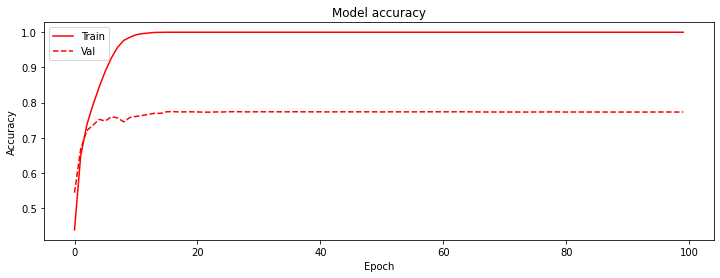

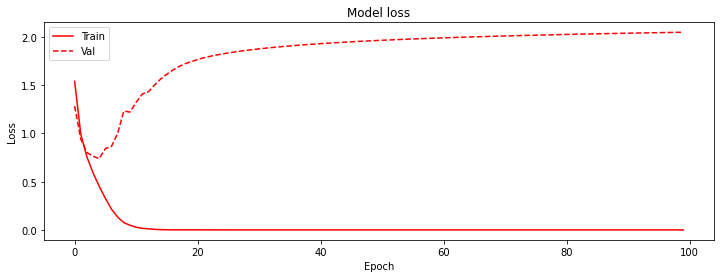

In [0]:
# Test set accuracy
_, base_test_acc = base_model.evaluate(test_batches, verbose = 0)
print("Baseline test accuracy: {}".format(base_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(base_history.history['categorical_accuracy'],'r', label = 'Train')
plt.plot(base_history.history['val_categorical_accuracy'],'r--', label = 'Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(base_history.history['loss'], 'r', label = 'Train')
plt.plot(base_history.history['val_loss'], 'r--', label = 'Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We can see that the training gets overfitted after around 10 epochs. Next step, I will apply regularization in order to reduce/overcome overfitting

#####Add dropout

In [0]:
def base_model_drop():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same', 
                          input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

base_model_drop = base_model_drop()
base_model_drop.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

In [0]:
base_drop_history = base_model_drop.fit(
      train_batches,
      epochs=100,
      validation_data=valid_batches)

Epoch 1/100
625/625 [==============================] - 8s 13ms/step - loss: 1.8585 - categorical_accuracy: 0.3049 - val_loss: 1.4751 - val_categorical_accuracy: 0.4627
Epoch 2/100
625/625 [==============================] - 9s 14ms/step - loss: 1.3621 - categorical_accuracy: 0.5013 - val_loss: 1.1505 - val_categorical_accuracy: 0.5821
Epoch 3/100
625/625 [==============================] - 9s 14ms/step - loss: 1.1352 - categorical_accuracy: 0.5903 - val_loss: 1.0398 - val_categorical_accuracy: 0.6312
Epoch 4/100
625/625 [==============================] - 9s 14ms/step - loss: 0.9780 - categorical_accuracy: 0.6525 - val_loss: 0.8738 - val_categorical_accuracy: 0.6880
Epoch 5/100
625/625 [==============================] - 9s 14ms/step - loss: 0.8738 - categorical_accuracy: 0.6862 - val_loss: 0.7910 - val_categorical_accuracy: 0.7182
Epoch 6/100
625/625 [==============================] - 9s 14ms/step - loss: 0.7983 - categorical_accuracy: 0.7167 - val_loss: 0.8277 - val_categorical_accuracy:

Baseline test accuracy: 0.771399974822998
Drop test accuracy: 0.8263999819755554


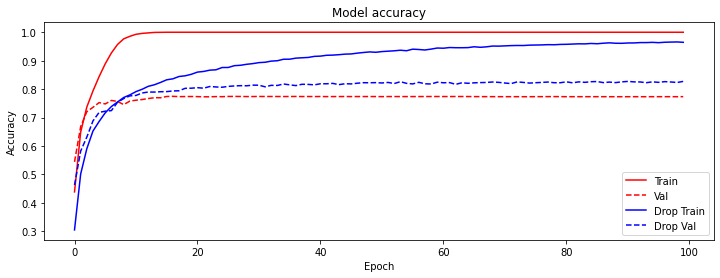

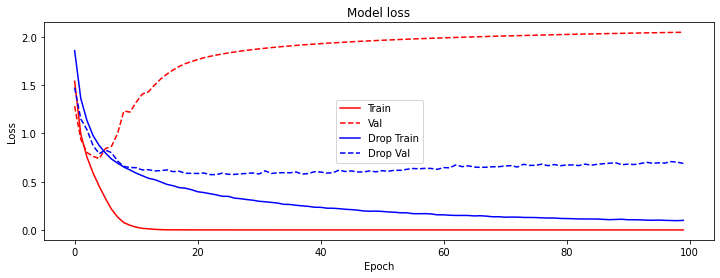

In [0]:
# Test set accuracy
print("Baseline test accuracy: {}".format(base_test_acc))
_, base_drop_test_acc = base_model_drop.evaluate(test_batches, verbose = 0)
print("Drop test accuracy: {}".format(base_drop_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(base_history.history['categorical_accuracy'],'r', label = 'Train')
plt.plot(base_history.history['val_categorical_accuracy'],'r--', label = 'Val')
plt.plot(base_drop_history.history['categorical_accuracy'],'b', label = 'Drop Train')
plt.plot(base_drop_history.history['val_categorical_accuracy'],'b--', label = 'Drop Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(base_history.history['loss'], 'r', label = 'Train')
plt.plot(base_history.history['val_loss'], 'r--', label = 'Val')
plt.plot(base_drop_history.history['loss'], 'b', label = 'Drop Train')
plt.plot(base_drop_history.history['val_loss'], 'b--', label = 'Drop Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Once again, dropout techniques produces very good results as it significantly reduces overfitting; test accuracy is also improved. However, there is still overfitting in training loss. Let's try other regularization techniques.

#####Add augmentation

In [0]:
batch_size = 64

#construct aug train pipeline
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20, zoom_range=0.15,	horizontal_flip=True, fill_mode="nearest")
train_datagen.fit(x_train)
aug_train_batches = train_datagen.flow(x_train, y_train, shuffle = True, batch_size=batch_size)

In [0]:
base_model_aug = base_model()
base_aug_history = base_model_aug.fit(
      aug_train_batches,
      steps_per_epoch = 100,
      epochs=100,
      validation_data=valid_batches)

Epoch 1/100
100/100 [==============================] - 3s 33ms/step - loss: 2.1013 - categorical_accuracy: 0.2311 - val_loss: 1.8043 - val_categorical_accuracy: 0.3472
Epoch 2/100
100/100 [==============================] - 3s 32ms/step - loss: 1.7426 - categorical_accuracy: 0.3700 - val_loss: 1.5876 - val_categorical_accuracy: 0.4187
Epoch 3/100
100/100 [==============================] - 3s 32ms/step - loss: 1.6203 - categorical_accuracy: 0.4127 - val_loss: 1.5136 - val_categorical_accuracy: 0.4443
Epoch 4/100
100/100 [==============================] - 3s 32ms/step - loss: 1.5100 - categorical_accuracy: 0.4448 - val_loss: 1.3758 - val_categorical_accuracy: 0.4984
Epoch 5/100
100/100 [==============================] - 3s 32ms/step - loss: 1.4388 - categorical_accuracy: 0.4761 - val_loss: 1.3663 - val_categorical_accuracy: 0.5081
Epoch 6/100
100/100 [==============================] - 3s 32ms/step - loss: 1.3585 - categorical_accuracy: 0.5081 - val_loss: 1.3187 - val_categorical_accuracy:

Baseline test accuracy: 0.771399974822998
Drop test accuracy: 0.8263999819755554
Aug test accuracy: 0.7979000210762024


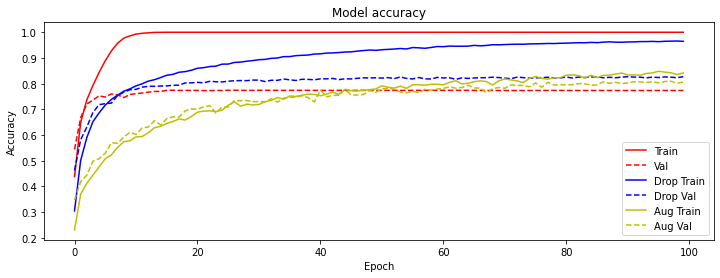

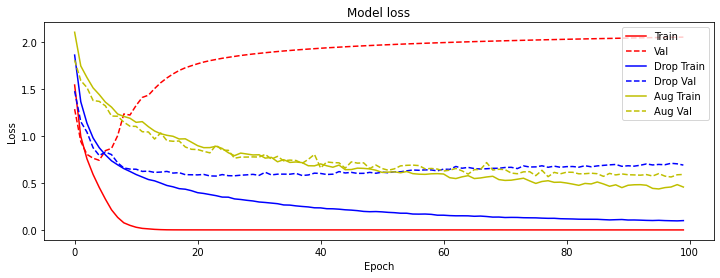

In [0]:
# Test set accuracy
print("Baseline test accuracy: {}".format(base_test_acc))
print("Drop test accuracy: {}".format(base_drop_test_acc))
_, base_aug_test_acc = base_model_aug.evaluate(test_batches, verbose = 0)
print("Aug test accuracy: {}".format(base_aug_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(base_history.history['categorical_accuracy'],'r', label = 'Train')
plt.plot(base_history.history['val_categorical_accuracy'],'r--', label = 'Val')
plt.plot(base_drop_history.history['categorical_accuracy'],'b', label = 'Drop Train')
plt.plot(base_drop_history.history['val_categorical_accuracy'],'b--', label = 'Drop Val')
plt.plot(base_aug_history.history['categorical_accuracy'],'y', label = 'Aug Train')
plt.plot(base_aug_history.history['val_categorical_accuracy'],'y--', label = 'Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(base_history.history['loss'], 'r', label = 'Train')
plt.plot(base_history.history['val_loss'], 'r--', label = 'Val')
plt.plot(base_drop_history.history['loss'], 'b', label = 'Drop Train')
plt.plot(base_drop_history.history['val_loss'], 'b--', label = 'Drop Val')
plt.plot(base_aug_history.history['loss'], 'y', label = 'Aug Train')
plt.plot(base_aug_history.history['val_loss'], 'y--', label = 'Aug Val')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

With data augmentation, the training does not get overfitted at all. Accuracy and loss also have better results than the baseline model. Although compared to model with dropout, test accuracy of augmentation model is lower, it is the most robust of all three models so far because there is no sign of overfitting.
In next section, I will apply combination of 2-3 regularization techniques into training including dropout+augmentation and dropout+augmentation+batchnormalization and compare the performance of all models' training.

#####Add dropout and augmentation

In [0]:
base_model_aug_drop = base_model_drop()
base_aug_drop_history = base_model_aug_drop.fit(
      aug_train_batches,
      steps_per_epoch = 100,
      epochs=100,
      validation_data=valid_batches)

Epoch 1/100
100/100 [==============================] - 3s 34ms/step - loss: 2.2677 - categorical_accuracy: 0.1508 - val_loss: 2.3378 - val_categorical_accuracy: 0.0998
Epoch 2/100
100/100 [==============================] - 3s 32ms/step - loss: 2.1485 - categorical_accuracy: 0.2069 - val_loss: 2.0589 - val_categorical_accuracy: 0.2530
Epoch 3/100
100/100 [==============================] - 3s 33ms/step - loss: 1.9799 - categorical_accuracy: 0.2645 - val_loss: 1.8783 - val_categorical_accuracy: 0.3176
Epoch 4/100
100/100 [==============================] - 3s 33ms/step - loss: 1.8131 - categorical_accuracy: 0.3159 - val_loss: 1.7231 - val_categorical_accuracy: 0.3634
Epoch 5/100
100/100 [==============================] - 3s 32ms/step - loss: 1.7108 - categorical_accuracy: 0.3716 - val_loss: 1.5968 - val_categorical_accuracy: 0.4122
Epoch 6/100
100/100 [==============================] - 3s 32ms/step - loss: 1.6408 - categorical_accuracy: 0.3933 - val_loss: 1.5527 - val_categorical_accuracy:

#####Add dropout, augmentation and batch normalization

I introduce Batch Normalization layers into the model, putting it after 'relu' activation but before MaxPooling and Dropout:

In [0]:
def base_model_drop_batch():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same', 
                          input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

base_model_aug_drop_batch = base_model_drop_batch()
base_model_aug_drop_batch.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 128)      

In [0]:
base_aug_drop_batch_history = base_model_aug_drop_batch.fit(
      aug_train_batches,
      steps_per_epoch = 100,
      epochs=100,
      validation_data=valid_batches)

Epoch 1/100
100/100 [==============================] - 4s 35ms/step - loss: 2.1172 - categorical_accuracy: 0.3098 - val_loss: 2.1789 - val_categorical_accuracy: 0.2564
Epoch 2/100
100/100 [==============================] - 3s 33ms/step - loss: 1.6733 - categorical_accuracy: 0.4137 - val_loss: 1.8680 - val_categorical_accuracy: 0.3454
Epoch 3/100
100/100 [==============================] - 3s 33ms/step - loss: 1.5527 - categorical_accuracy: 0.4569 - val_loss: 1.7055 - val_categorical_accuracy: 0.4053
Epoch 4/100
100/100 [==============================] - 3s 33ms/step - loss: 1.4700 - categorical_accuracy: 0.4863 - val_loss: 1.4490 - val_categorical_accuracy: 0.4802
Epoch 5/100
100/100 [==============================] - 3s 33ms/step - loss: 1.3947 - categorical_accuracy: 0.5052 - val_loss: 1.7191 - val_categorical_accuracy: 0.4505
Epoch 6/100
100/100 [==============================] - 3s 33ms/step - loss: 1.3348 - categorical_accuracy: 0.5217 - val_loss: 1.4817 - val_categorical_accuracy:

#####Performance comparison

Baseline test accuracy: 0.771399974822998
Drop test accuracy: 0.8263999819755554
Aug test accuracy: 0.7979000210762024
Drop+Aug test accuracy: 0.7576000094413757
Drop+Aug+Batch test accuracy: 0.7822999954223633


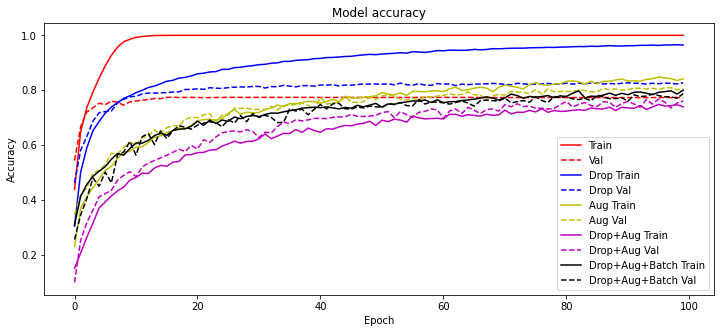

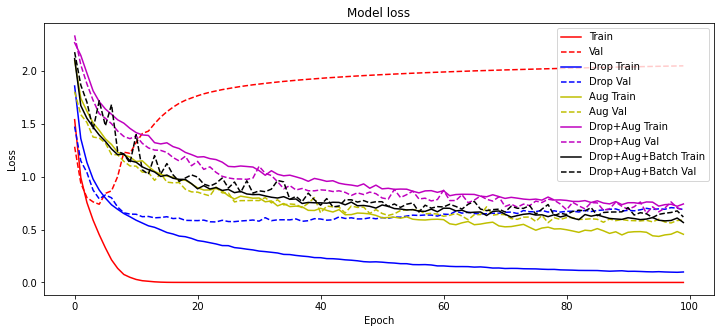

In [0]:
# Test set accuracy
print("Baseline test accuracy: {}".format(base_test_acc))
print("Drop test accuracy: {}".format(base_drop_test_acc))
print("Aug test accuracy: {}".format(base_aug_test_acc))
print("Drop+Aug test accuracy: {}".format(base_aug_drop_test_acc))
_, base_aug_drop_batch_test_acc = base_model_aug_drop_batch.evaluate(test_batches, verbose = 0)
print("Drop+Aug+Batch test accuracy: {}".format(base_aug_drop_batch_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,5))
plt.plot(base_history.history['categorical_accuracy'],'r', label = 'Train')
plt.plot(base_history.history['val_categorical_accuracy'],'r--', label = 'Val')
plt.plot(base_drop_history.history['categorical_accuracy'],'b', label = 'Drop Train')
plt.plot(base_drop_history.history['val_categorical_accuracy'],'b--', label = 'Drop Val')
plt.plot(base_aug_history.history['categorical_accuracy'],'y', label = 'Aug Train')
plt.plot(base_aug_history.history['val_categorical_accuracy'],'y--', label = 'Aug Val')
plt.plot(base_aug_drop_history.history['categorical_accuracy'],'m', label = 'Drop+Aug Train')
plt.plot(base_aug_drop_history.history['val_categorical_accuracy'],'m--', label = 'Drop+Aug Val')
plt.plot(base_aug_drop_batch_history.history['categorical_accuracy'],'k', label = 'Drop+Aug+Batch Train')
plt.plot(base_aug_drop_batch_history.history['val_categorical_accuracy'],'k--', label = 'Drop+Aug+Batch Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,5))
plt.plot(base_history.history['loss'], 'r', label = 'Train')
plt.plot(base_history.history['val_loss'], 'r--', label = 'Val')
plt.plot(base_drop_history.history['loss'], 'b', label = 'Drop Train')
plt.plot(base_drop_history.history['val_loss'], 'b--', label = 'Drop Val')
plt.plot(base_aug_history.history['loss'], 'y', label = 'Aug Train')
plt.plot(base_aug_history.history['val_loss'], 'y--', label = 'Aug Val')
plt.plot(base_aug_drop_history.history['loss'], 'm', label = 'Drop+Aug Train')
plt.plot(base_aug_drop_history.history['val_loss'], 'm--', label = 'Drop+Aug Val')
plt.plot(base_aug_drop_batch_history.history['loss'], 'k', label = 'Drop+Aug+Batch Train')
plt.plot(base_aug_drop_batch_history.history['val_loss'], 'k--', label = 'Drop+Aug+Batch Val')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Conclusion:
- Out of 5 models, model with dropout only produces the highest test accuracy; however, this model training gets overfitted after around 20 epochs, indicating low generalization capacity
- The last 3 models which are model with data augmentation, model with dropout and data augmentation and model with three combination dropout+augmentation+batch normalization have relatively similar training pattern: no overfitting and same level of optimization capacity.
- Among the above models, ConvNet model with only data augmentation produces the second highest test accuracy, but is the most robust model. This model will be used to compare with the ResNet model constructed in the next part.

#### Task 2.1.3 Train a ResNet

Train a residual neural network (ResNet) on the CIFAR10 training data and report the test accuracy and the training time.

The ResNet is a popular network architecture for image classification. You may find more information about how ResNet works by reading this [paper](https://arxiv.org/abs/1512.03385).


*(You may implement a resnet model or use an existing implementation. In either case, you should not use pretrained network weights.)*

#####Define a residual block

Firstly, I will define the residual module. A residual block consists of two convolutional layers with the same number of filters and a small filter size where the input to the block is added to the output of the block, this is called a shortcut connection (He at al, 2016). We can implement this directly in Keras using the functional API and the add() merge function (Brownie, 2019):

```
# function for creating an identity residual module
def residual_module(layer_in, n_filters):
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, layer_in])
	# activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out
```

However, this direct implementation will throw error if the number of filters in the input layer does not match the number of filters in the last convolutional layer of the residual module (n_filters). One possible solution is to use a 1×1 convolution layer as a projection shortcut, to either increase or reduce the number of filters in the last convolutional layer of the residual module (He at al, 2016). I will use this project shortcut in my definition below.

Besides, as in He at al (2016) experiments, I built a single 2D Convolution-Batch Normalization-Activation layer followed by 3 x three-2D Convolution-Batch Normalization-Activation residual layer blocks and topped on with a Dense layer. I used 'same' padding,  'relu' activation and 'he_normal' weight initialization. At the start of each block, the number of channels/filters is doubled while feature map size is halved. I set n_filters manually while strides = 2 in the layer_in of each block to create feature map size halving effect.

In the original paper, He at al (2016) also used weight decay of 0.0001. However, I will not adopt this technique in this part but in next part 'Fast training of ResNet' in order to compare the impact of different regularization techniques.


In [0]:
from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Dense, Flatten, AveragePooling2D, add 

def residual_module(layer_in, n_filters, strides = 2):
  if layer_in.shape[-1] != n_filters:
    layer_in = Conv2D(n_filters, (1,1), strides = strides, padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

  conv1 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(layer_in)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)

  conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
  conv2 = BatchNormalization()(conv2)
  layer_out = add([conv2, layer_in])
  layer_out = Activation('relu')(layer_out)
  return layer_out

#####Reconstruct an alike ResNet20 model architecture 

In this part I will recreate an alike ResNet20 model using the residual block function defined previously with project shortcuts to match dimensions. Below is the model architecture:

In [0]:
# define model input
visible = Input(shape=(32, 32, 3))

# add residual module
conv = Conv2D(16, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(visible)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
res1 = residual_module(conv, 16)
res2 = residual_module(res1, 16)
res3 = residual_module(res2, 16)
res4 = residual_module(res3, 32)
res5 = residual_module(res4, 32)
res6 = residual_module(res5, 32)
res7 = residual_module(res6, 64)
res8 = residual_module(res7, 64)
res9 = residual_module(res8, 64)
pooling = AveragePooling2D(pool_size=8)(res9)
flatten = Flatten()(pooling)
outputs = Dense(10, activation='softmax',
                    kernel_initializer='he_normal')(flatten)
# create model
res_model = Model(inputs=visible, outputs=outputs)
# summarize model
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

#####ResNet Baseline model

Now I'll run the model for 100 epochs. Let's see the results:

In [0]:
%%time 
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

res_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
res_history = res_model.fit(x_train, y_train, epochs = 100, batch_size = batch_size,
          validation_data=(x_valid, y_valid))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 52s 1ms/step - loss: 1.4903 - categorical_accuracy: 0.4563 - val_loss: 1.4833 - val_categorical_accuracy: 0.4636
Epoch 2/100
40000/40000 [==============================] - 43s 1ms/step - loss: 1.1144 - categorical_accuracy: 0.5985 - val_loss: 1.1852 - val_categorical_accuracy: 0.5768
Epoch 3/100
40000/40000 [==============================] - 43s 1ms/step - loss: 0.9643 - categorical_accuracy: 0.6542 - val_loss: 1.0714 - val_categorical_accuracy: 0.6154
Epoch 4/100
40000/40000 [==============================] - 43s 1ms/step - loss: 0.8697 - categorical_accuracy: 0.6900 - val_loss: 0.9859 - val_categorical_accuracy: 0.6480
Epoch 5/100
40000/40000 [==============================] - 43s 1ms/step - loss: 0.7987 - categorical_accuracy: 0.7158 - val_loss: 0.8814 - val_categorical_accuracy: 0.6897
Epoch 6/100
40000/40000 [==============================] - 43s 1ms/step - loss: 0.7311 - c

ResNet accuracy: 0.6949999928474426


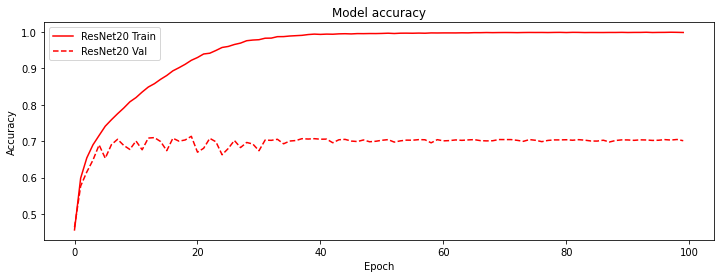

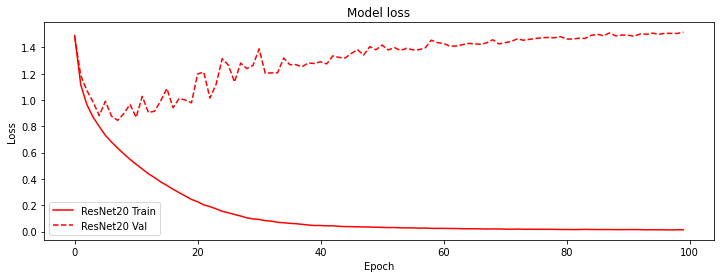

In [0]:
# Test accuracy
_, res_test_acc = res_model.evaluate(x_test, y_test, verbose = 0)
print('ResNet accuracy:', res_test_acc)

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['categorical_accuracy'],'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_categorical_accuracy'],'r--', label = 'ResNet20 Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['loss'], 'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_loss'], 'r--', label = 'ResNet20 Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Training ResNet20 model without regularization for 100 epochs takes more than 1 hour but only produces test accuracy of almost 70%. Also, this model training gets overfitted after 8-9 epochs, indicating low generalization capacity. In the next part, I will introduce regularization techniques to the model to improve training performance.

### Task 2.2 Fast training of ResNet

*(weight ~10%)*

In this task, you will experiment with different ways to reduce the time for training your ResNet on CIFAR10. There are different ways to speed up neural network training; below are two ideas. Please select at least one idea to implement. Explain the experiment steps and report the final performance and training time.

#### Option 1. Learning rate schedule

Use a learning rate schedule for the training. Some popular learning rate schedules include 

- the Step Decay learning rate (e.g., see [here](https://github.com/kuangliu/pytorch-cifar))
- [Cyclical learning rates](https://arxiv.org/abs/1506.01186)
- [The exponential learning rate](https://openreview.net/forum?id=rJg8TeSFDH) 

Also Keras provides [some convenient functions](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) that you can use.


#### Option 2. Look ahead optimiser

Read [this paper](https://arxiv.org/abs/1907.08610) and implement the Lookahead optimiser.

#####ResNet with exponential learning rate decay

In this section, I will apply exponential learning rate decay instead of the time-based learning rate decay I have been using so far and run the for 100 epochs and compare with ResNet baseline model.

In [0]:
%%time
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96)

lr_model = Model(inputs=visible, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

lr_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
lr_history = lr_model.fit(x_train, y_train, epochs = 100, batch_size = batch_size,
          validation_data=(x_valid, y_valid))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 46s 1ms/step - loss: 2.1733 - categorical_accuracy: 0.2311 - val_loss: 2.6112 - val_categorical_accuracy: 0.1926
Epoch 2/100
40000/40000 [==============================] - 43s 1ms/step - loss: 1.4924 - categorical_accuracy: 0.4543 - val_loss: 1.6357 - val_categorical_accuracy: 0.3961
Epoch 3/100
40000/40000 [==============================] - 43s 1ms/step - loss: 1.2764 - categorical_accuracy: 0.5390 - val_loss: 1.3228 - val_categorical_accuracy: 0.5301
Epoch 4/100
40000/40000 [==============================] - 43s 1ms/step - loss: 1.1116 - categorical_accuracy: 0.5982 - val_loss: 1.2199 - val_categorical_accuracy: 0.5714
Epoch 5/100
40000/40000 [==============================] - 43s 1ms/step - loss: 0.9898 - categorical_accuracy: 0.6450 - val_loss: 1.0279 - val_categorical_accuracy: 0.6368
Epoch 6/100
40000/40000 [==============================] - 43s 1ms/step - loss: 0.8886 - c

ResNet accuracy: 0.6949999928474426
ExpoDecay accuracy: 0.7153000235557556


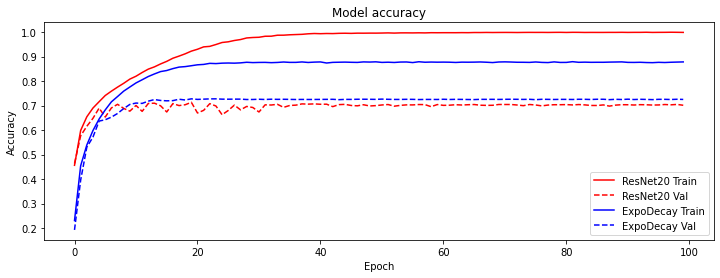

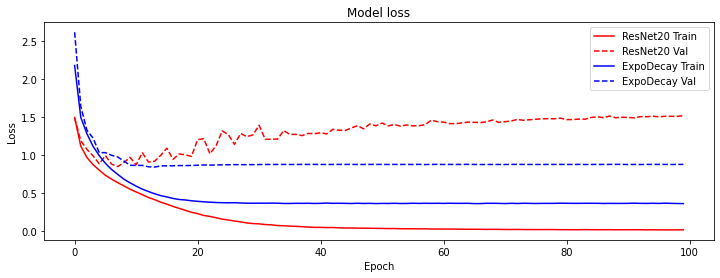

In [0]:
# Test accuracy
print('ResNet accuracy:', res_test_acc)
_, lr_test_acc = lr_model.evaluate(x_test, y_test, verbose = 0)
print('ExpoDecay accuracy:', lr_test_acc)

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['categorical_accuracy'],'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_categorical_accuracy'],'r--', label = 'ResNet20 Val')
plt.plot(lr_history.history['categorical_accuracy'],'b', label = 'ExpoDecay Train')
plt.plot(lr_history.history['val_categorical_accuracy'],'b--', label = 'ExpoDecay Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['loss'], 'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_loss'], 'r--', label = 'ResNet20 Val')
plt.plot(lr_history.history['loss'], 'b', label = 'ExpoDecay Train')
plt.plot(lr_history.history['val_loss'], 'b--', label = 'ExpoDecay Val')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Learning rate decay has a positive impact on the model training as it significantly reduces overfitting and improve test accuracy. However, the training time still remains the same, more than 1 hour training.

####ResNet with data augmentation

In this section, I apply data augmentation into training. When fitting the model, I set steps per epoch = 100 steps in order to reduce the running time.

In [0]:
batch_size = 64
#construct aug train pipeline
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20, zoom_range=0.15, horizontal_flip=True, fill_mode="nearest")
train_datagen.fit(x_train)
aug_train_batches = train_datagen.flow(x_train, y_train, shuffle = True, batch_size=batch_size)

In [0]:
%%time
aug_res_model = Model(inputs=visible, outputs=outputs)

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

aug_res_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
aug_res_history = aug_res_model.fit(aug_train_batches, steps_per_epoch= 100,
                                    epochs = 100, validation_data=(x_valid, y_valid))

Epoch 1/100
100/100 [==============================] - 14s 137ms/step - loss: 0.7584 - categorical_accuracy: 0.7808 - val_loss: 1.0613 - val_categorical_accuracy: 0.7023
Epoch 2/100
100/100 [==============================] - 10s 99ms/step - loss: 0.7335 - categorical_accuracy: 0.7967 - val_loss: 0.7626 - val_categorical_accuracy: 0.7853
Epoch 3/100
100/100 [==============================] - 10s 99ms/step - loss: 0.7593 - categorical_accuracy: 0.7819 - val_loss: 0.8305 - val_categorical_accuracy: 0.7591
Epoch 4/100
100/100 [==============================] - 10s 99ms/step - loss: 0.7461 - categorical_accuracy: 0.7847 - val_loss: 0.8190 - val_categorical_accuracy: 0.7711
Epoch 5/100
100/100 [==============================] - 10s 99ms/step - loss: 0.7458 - categorical_accuracy: 0.7837 - val_loss: 0.7288 - val_categorical_accuracy: 0.7998
Epoch 6/100
100/100 [==============================] - 10s 99ms/step - loss: 0.7437 - categorical_accuracy: 0.7856 - val_loss: 0.7703 - val_categorical_ac

ResNet accuracy: 0.6949999928474426
ExpoDecay accuracy: 0.7153000235557556
Aug accuracy: 0.8209999799728394


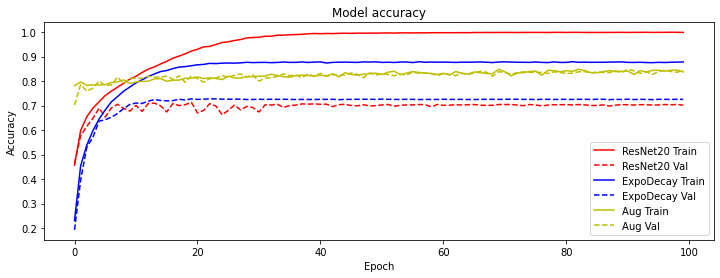

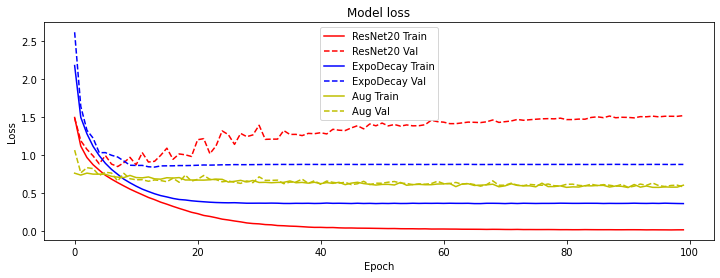

In [0]:
# Test accuracy
print('ResNet accuracy:', res_test_acc)
print('ExpoDecay accuracy:', lr_test_acc)
_, aug_res_test_acc = aug_res_model.evaluate(x_test, y_test, verbose = 0)
print('Aug accuracy:', aug_res_test_acc)

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['categorical_accuracy'],'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_categorical_accuracy'],'r--', label = 'ResNet20 Val')
plt.plot(lr_history.history['categorical_accuracy'],'b', label = 'ExpoDecay Train')
plt.plot(lr_history.history['val_categorical_accuracy'],'b--', label = 'ExpoDecay Val')
plt.plot(aug_res_history.history['categorical_accuracy'],'y', label = 'Aug Train')
plt.plot(aug_res_history.history['val_categorical_accuracy'],'y--', label = 'Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['loss'], 'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_loss'], 'r--', label = 'ResNet20 Val')
plt.plot(lr_history.history['loss'], 'b', label = 'ExpoDecay Train')
plt.plot(lr_history.history['val_loss'], 'b--', label = 'ExpoDecay Val')
plt.plot(aug_res_history.history['loss'], 'y', label = 'Aug Train')
plt.plot(aug_res_history.history['val_loss'], 'y--', label = 'Aug Val')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Data augmentation is a good regularization technique in terms of eliminating overfitting; however, training seems to oscalitate around 80% and not to improve with the given time-based learning rate decay. In the next section, I'll combine exponential learning rate decay with data augmentation.

####ResNet with data augmentation and exponential learning rate decay

In this section I combine two regularization techniques which are data augmentation and expo learning rate

In [0]:
%%time
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96)

lr_aug_model = Model(inputs=visible, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

lr_aug_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
lr_aug_history = lr_aug_model.fit(aug_train_batches, epochs = 100, steps_per_epoch = 100,
                                   validation_data=(x_valid, y_valid))

Epoch 1/100
100/100 [==============================] - 13s 130ms/step - loss: 0.7949 - categorical_accuracy: 0.7214 - val_loss: 1.4449 - val_categorical_accuracy: 0.5791
Epoch 2/100
100/100 [==============================] - 10s 96ms/step - loss: 0.7798 - categorical_accuracy: 0.7347 - val_loss: 1.0994 - val_categorical_accuracy: 0.6535
Epoch 3/100
100/100 [==============================] - 10s 98ms/step - loss: 0.7732 - categorical_accuracy: 0.7348 - val_loss: 1.1953 - val_categorical_accuracy: 0.6399
Epoch 4/100
100/100 [==============================] - 10s 96ms/step - loss: 0.7552 - categorical_accuracy: 0.7336 - val_loss: 1.2737 - val_categorical_accuracy: 0.6019
Epoch 5/100
100/100 [==============================] - 10s 96ms/step - loss: 0.7534 - categorical_accuracy: 0.7417 - val_loss: 1.0994 - val_categorical_accuracy: 0.6376
Epoch 6/100
100/100 [==============================] - 10s 96ms/step - loss: 0.7177 - categorical_accuracy: 0.7539 - val_loss: 1.2400 - val_categorical_ac

ResNet accuracy: 0.6949999928474426
ExpoDecay accuracy: 0.7153000235557556
Aug accuracy: 0.7706999778747559
ExpoDecay+Aug accuracy: 0.8256000280380249


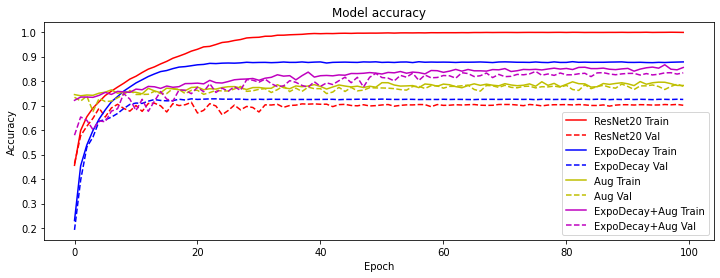

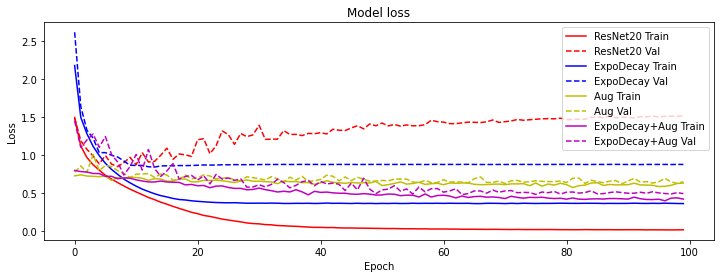

In [0]:
# Test accuracy
print('ResNet accuracy:', res_test_acc)
print('ExpoDecay accuracy:', lr_test_acc)
print('Aug accuracy:', aug_res_test_acc)
_, lr_aug_test_acc = lr_aug_model.evaluate(x_test, y_test, verbose = 0)
print('ExpoDecay+Aug accuracy:', lr_aug_test_acc)

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['categorical_accuracy'],'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_categorical_accuracy'],'r--', label = 'ResNet20 Val')
plt.plot(lr_history.history['categorical_accuracy'],'b', label = 'ExpoDecay Train')
plt.plot(lr_history.history['val_categorical_accuracy'],'b--', label = 'ExpoDecay Val')
plt.plot(aug_res_history.history['categorical_accuracy'],'y', label = 'Aug Train')
plt.plot(aug_res_history.history['val_categorical_accuracy'],'y--', label = 'Aug Val')
plt.plot(lr_aug_history.history['categorical_accuracy'],'m', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_categorical_accuracy'],'m--', label = 'ExpoDecay+Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['loss'], 'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_loss'], 'r--', label = 'ResNet20 Val')
plt.plot(lr_history.history['loss'], 'b', label = 'ExpoDecay Train')
plt.plot(lr_history.history['val_loss'], 'b--', label = 'ExpoDecay Val')
plt.plot(aug_res_history.history['loss'], 'y', label = 'Aug Train')
plt.plot(aug_res_history.history['val_loss'], 'y--', label = 'Aug Val')
plt.plot(lr_aug_history.history['loss'], 'm', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_loss'], 'm--', label = 'ExpoDecay+Aug Val')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Model with both exponential learning rate decay and data augmentation is the most robust and impactful so far since training is not getting overfitted and it has higher test accuracy (82.56%). Also training time is only more than 16 minutes, which is very efficient.

####ResNet with data augmentation, exponential learning rate decay and weight decay

As mentioned previously, I will apply weight decay as a technique to regularize training. I will combine all three techniques which are data augmentation, exponential learning rate decay and weight decay in this part. In order to implement weight regularization, I re-define the residual layer, adding weight decay of 0.0001 into residual layers and also the very first convolution layer of the model.

In [0]:
from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D
from keras.layers import Dense, Flatten, AveragePooling2D, add 

def residual_module(layer_in, n_filters, strides = 2):
  if layer_in.shape[-1] != n_filters:
    layer_in = Conv2D(n_filters, (1,1), strides = strides, padding='same', activation='relu', 
                      kernel_regularizer=l2(1e-4), kernel_initializer='he_normal')(layer_in)

  conv1 = Conv2D(n_filters, (3,3), padding='same', activation='linear',
                 kernel_regularizer=l2(1e-4), kernel_initializer='he_normal')(layer_in)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)

  conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear',
                 kernel_regularizer=l2(1e-4), kernel_initializer='he_normal')(conv1)
  conv2 = BatchNormalization()(conv2)
  layer_out = add([conv2, layer_in])
  layer_out = Activation('relu')(layer_out)
  return layer_out

# define model input
visible = Input(shape=(32, 32, 3))

# add residual module
conv = Conv2D(16, (3,3), padding='same', activation='linear', 
              kernel_regularizer=l2(1e-4), kernel_initializer='he_normal')(visible)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
res1 = residual_module(conv, 16)
res2 = residual_module(res1, 16)
res3 = residual_module(res2, 16)
res4 = residual_module(res3, 32)
res5 = residual_module(res4, 32)
res6 = residual_module(res5, 32)
res7 = residual_module(res6, 64)
res8 = residual_module(res7, 64)
res9 = residual_module(res8, 64)
pooling = AveragePooling2D(pool_size=8)(res9)
flatten = Flatten()(pooling)
outputs = Dense(10, activation='softmax',
                    kernel_initializer='he_normal')(flatten)

Then I will train this model for 100 epochs:

In [0]:
%%time
# create model
l2_model = Model(inputs=visible, outputs=outputs)

initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96)

l2_model = Model(inputs=visible, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

l2_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
l2_history = l2_model.fit(aug_train_batches, epochs = 100, steps_per_epoch = 100,
                          validation_data=(x_valid, y_valid))

Epoch 1/100
100/100 [==============================] - 13s 130ms/step - loss: 2.6775 - categorical_accuracy: 0.1400 - val_loss: 5.3454 - val_categorical_accuracy: 0.1035
Epoch 2/100
100/100 [==============================] - 10s 98ms/step - loss: 2.1557 - categorical_accuracy: 0.2452 - val_loss: 2.1840 - val_categorical_accuracy: 0.2361
Epoch 3/100
100/100 [==============================] - 10s 98ms/step - loss: 1.9643 - categorical_accuracy: 0.3258 - val_loss: 2.9540 - val_categorical_accuracy: 0.2013
Epoch 4/100
100/100 [==============================] - 10s 98ms/step - loss: 1.8605 - categorical_accuracy: 0.3727 - val_loss: 2.0158 - val_categorical_accuracy: 0.3530
Epoch 5/100
100/100 [==============================] - 10s 98ms/step - loss: 1.7696 - categorical_accuracy: 0.4091 - val_loss: 1.7699 - val_categorical_accuracy: 0.4005
Epoch 6/100
100/100 [==============================] - 10s 98ms/step - loss: 1.7340 - categorical_accuracy: 0.4214 - val_loss: 1.8181 - val_categorical_ac

### Task 2.3 Performance comparison

*(weight ~3%)*

Based on the above experiments, which method or which combination of methods result in the best accuracy with the same training time.

- Comparison among ResNet models: According to the results, ExpoDecay+Aug produces the highest accuracy and also has the shortest run time. Below table gives detailed information:

|Model|ExpoDecay|Data Augmentation|Weight Decay|Run time|Test accuracy(%)|Overfitted|
|---|---|---|---|---|---|---|
|Baseline| N|N |N |1h19 |69.5 |Y|
|1| Y|N |N |1h19 |71.5 |Y|
|2| N|Y |N |16m39 |77.06 |N|
|3| **Y**|**Y** |**N** |**16m06** |**82.56** |**N**|
|4| Y|Y |Y |16m30 |79.55 |N|


ResNet accuracy: 0.6949999928474426
ExpoDecay accuracy: 0.7153000235557556
Aug accuracy: 0.7706999778747559
ExpoDecay+Aug accuracy: 0.8256000280380249
ExpoDecay+Aug+L2Decay accuracy: 0.7955999970436096


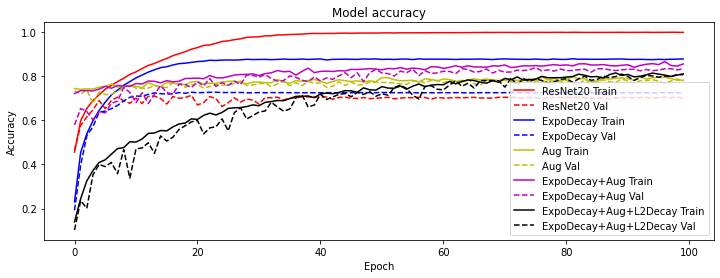

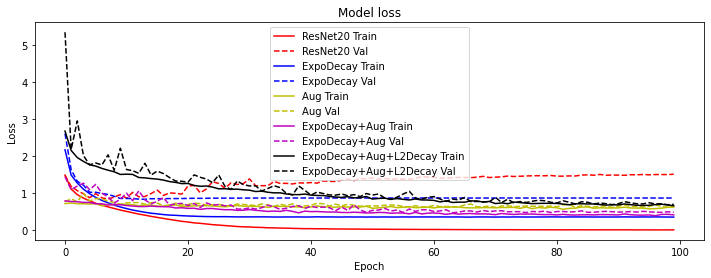

In [0]:
# Test accuracy
print('ResNet accuracy:', res_test_acc)
print('ExpoDecay accuracy:', lr_test_acc)
print('Aug accuracy:', aug_res_test_acc)
print('ExpoDecay+Aug accuracy:', lr_aug_test_acc)
_, l2_test_acc = l2_model.evaluate(x_test, y_test, verbose = 0)
print('ExpoDecay+Aug+L2Decay accuracy:', l2_test_acc)

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['categorical_accuracy'],'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_categorical_accuracy'],'r--', label = 'ResNet20 Val')
plt.plot(lr_history.history['categorical_accuracy'],'b', label = 'ExpoDecay Train')
plt.plot(lr_history.history['val_categorical_accuracy'],'b--', label = 'ExpoDecay Val')
plt.plot(aug_res_history.history['categorical_accuracy'],'y', label = 'Aug Train')
plt.plot(aug_res_history.history['val_categorical_accuracy'],'y--', label = 'Aug Val')
plt.plot(lr_aug_history.history['categorical_accuracy'],'m', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_categorical_accuracy'],'m--', label = 'ExpoDecay+Aug Val')
plt.plot(l2_history.history['categorical_accuracy'],'k', label = 'ExpoDecay+Aug+L2Decay Train')
plt.plot(l2_history.history['val_categorical_accuracy'],'k--', label = 'ExpoDecay+Aug+L2Decay Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(res_history.history['loss'], 'r', label = 'ResNet20 Train')
plt.plot(res_history.history['val_loss'], 'r--', label = 'ResNet20 Val')
plt.plot(lr_history.history['loss'], 'b', label = 'ExpoDecay Train')
plt.plot(lr_history.history['val_loss'], 'b--', label = 'ExpoDecay Val')
plt.plot(aug_res_history.history['loss'], 'y', label = 'Aug Train')
plt.plot(aug_res_history.history['val_loss'], 'y--', label = 'Aug Val')
plt.plot(lr_aug_history.history['loss'], 'm', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_loss'], 'm--', label = 'ExpoDecay+Aug Val')
plt.plot(l2_history.history['loss'], 'k', label = 'ExpoDecay+Aug+L2Decay Train')
plt.plot(l2_history.history['val_loss'], 'k--', label = 'ExpoDecay+Aug+L2Decay Val')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

- Comparison between ConvNet and ResNet models: We can see that the best ResNet model (with ExpoDecay and data augmentation) outperforms the best ConvNet model (which uses only data augmentation) in terms of test accuracy. Below table summarizes this conclusion:

|Model|Dropout|ExpoDecay|Data Augmentation|Weight Decay|Batch Normalization|Run time|Test accuracy(%)|Overfitted|
|--|---|---|---|---|---|---|---|--|
|Baseline ConvNet|N| N|N |N |N|- |77.13 |Y|
|ConvNet|Y| N|N |N |N|- |82.63 |Y|
|**ConvNet**|**N**|**N**|**Y** |**N**|**N**|- |**79.79** |**N**|
|ConvNet|Y| N|Y |N |N|- |75.76 |N|
|ConvNet|Y| N|Y |N |Y|- |78.22 |N|
|Baseline ResNet|N| N|N |N |Y|1h19 |69.5 |Y|
|ResNet|N| Y|N |N |Y|1h19 |71.5 |Y|
|ResNet|N| N|Y |N |Y|16m39 |77.06 |N|
|**ResNet**|**N**| **Y**|**Y** |**N** |**Y**|**16m06** |**82.56** |**N**|
|ResNet|N| Y|Y |Y |Y|16m30 |79.55 |N|







Baseline test accuracy: 0.771399974822998
Drop test accuracy: 0.8263999819755554
Aug test accuracy: 0.7979000210762024
Drop+Aug test accuracy: 0.7576000094413757
Drop+Aug+Batch test accuracy: 0.7822999954223633


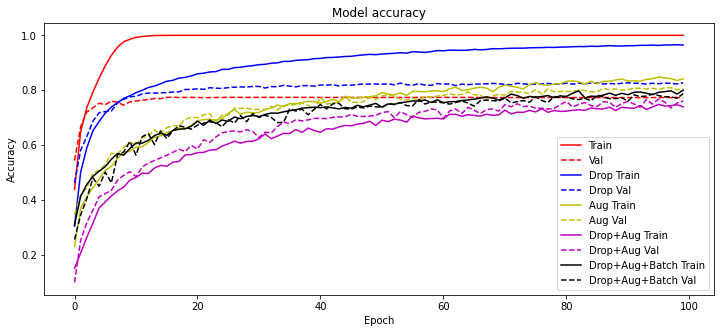

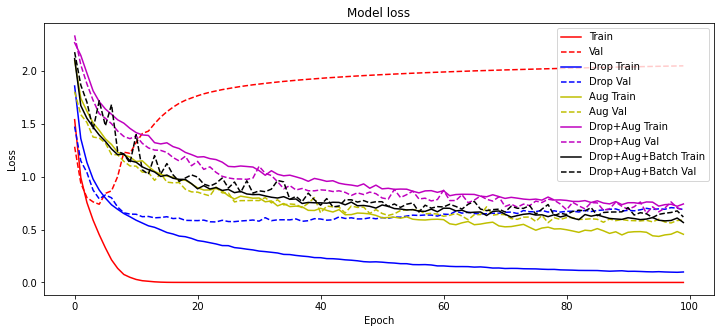

In [0]:
# Graphs showing performance of ConvNet models

####ResNet with data augmentation and exponential learning rate decay (200 epochs)

In this part, I will run ExpoDecay+Aug model for 200 epochs. Here are some experiments I tried:

|Model|Decay steps|Decay rate|Step per epoch|No epochs|Run time|Test accuracy(%)|
|--|---|---|---|---|---|---|
|Baseline ExpoDecay+Aug| 100|0.96 |100|100|16m06 |82.56 |
|1| 200|0.965 |400|200|42m43 |81.95 |
|**2**| **200**|**0.965** |**500**|**200**|**02h08** |**83.38** |
|3| 200|0.965 |750|200| 01h16| 82.23|
|4| 200|0.96 |750|200|2h51 |81.31 |


According to the table:
- In terms of test accuracy, model 2 is the most powerful since it can achieve 83.38% of accuracy regarding test predictions.
- In terms of run time, the baseline ExpoDecay+Aug model is the best one as only after 16 minutes of training, it is able to achieve 82.56% of accuracy regarding test predictions.

In [0]:
%%time
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.965)

lr_aug_model = Model(inputs=visible, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

lr_aug_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
lr_aug_history = lr_aug_model.fit(aug_train_batches, epochs = 200, steps_per_epoch = 400,
                                   validation_data=(x_valid, y_valid), validation_steps = 10)

Epoch 1/200
400/400 [==============================] - 15s 38ms/step - loss: 2.0198 - categorical_accuracy: 0.2707 - val_loss: 1.9389 - val_categorical_accuracy: 0.3146
Epoch 2/200
400/400 [==============================] - 13s 32ms/step - loss: 1.5517 - categorical_accuracy: 0.4296 - val_loss: 1.6603 - val_categorical_accuracy: 0.4069
Epoch 3/200
400/400 [==============================] - 13s 31ms/step - loss: 1.4084 - categorical_accuracy: 0.4917 - val_loss: 1.4387 - val_categorical_accuracy: 0.4652
Epoch 4/200
400/400 [==============================] - 13s 32ms/step - loss: 1.3327 - categorical_accuracy: 0.5140 - val_loss: 1.4922 - val_categorical_accuracy: 0.4787
Epoch 5/200
400/400 [==============================] - 13s 32ms/step - loss: 1.2543 - categorical_accuracy: 0.5470 - val_loss: 1.4507 - val_categorical_accuracy: 0.4815
Epoch 6/200
400/400 [==============================] - 13s 32ms/step - loss: 1.1721 - categorical_accuracy: 0.5797 - val_loss: 1.2584 - val_categorical_acc

ExpoDecay+Aug test accuracy: 0.8195000290870667


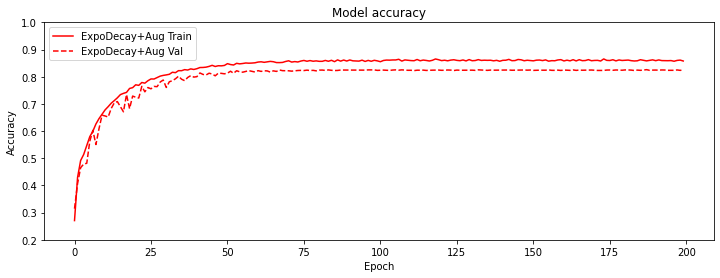

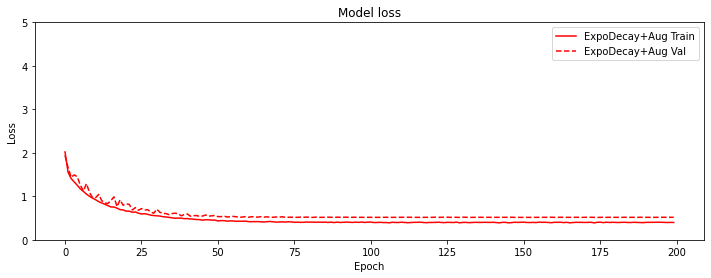

In [0]:
# Test set accuracy
_, lr_aug_test_acc = lr_aug_model.evaluate(x_test, y_test, verbose = 0)
print("ExpoDecay+Aug test accuracy: {}".format(lr_aug_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(lr_aug_history.history['categorical_accuracy'],'r', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_categorical_accuracy'],'r--', label = 'ExpoDecay+Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.2,1)
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(lr_aug_history.history['loss'], 'r', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_loss'], 'r--', label = 'ExpoDecay+Aug Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,5)
plt.legend()
plt.show()

In [0]:
%%time
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.965)

lr_aug_model = Model(inputs=visible, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

lr_aug_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
lr_aug_history = lr_aug_model.fit(aug_train_batches, epochs = 200, steps_per_epoch = 500,
                                   validation_data=(x_valid, y_valid), validation_steps = 10)

Epoch 1/200
500/500 [==============================] - 48s 97ms/step - loss: 1.8969 - categorical_accuracy: 0.3107 - val_loss: 1.8163 - val_categorical_accuracy: 0.3653
Epoch 2/200
500/500 [==============================] - 39s 77ms/step - loss: 1.4959 - categorical_accuracy: 0.4538 - val_loss: 1.6860 - val_categorical_accuracy: 0.4310
Epoch 3/200
500/500 [==============================] - 39s 77ms/step - loss: 1.2829 - categorical_accuracy: 0.5381 - val_loss: 1.8247 - val_categorical_accuracy: 0.4621
Epoch 4/200
500/500 [==============================] - 39s 77ms/step - loss: 1.1657 - categorical_accuracy: 0.5819 - val_loss: 1.1132 - val_categorical_accuracy: 0.6038
Epoch 5/200
500/500 [==============================] - 39s 77ms/step - loss: 1.0610 - categorical_accuracy: 0.6232 - val_loss: 1.2652 - val_categorical_accuracy: 0.5714
Epoch 6/200
500/500 [==============================] - 39s 77ms/step - loss: 0.9769 - categorical_accuracy: 0.6535 - val_loss: 1.2081 - val_categorical_acc

ExpoDecay+Aug test accuracy: 0.8338000178337097


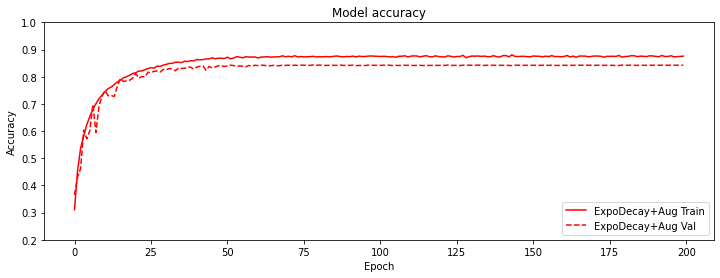

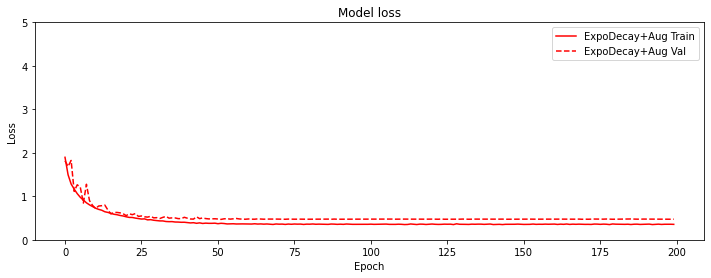

In [0]:
# Test set accuracy
_, lr_aug_test_acc = lr_aug_model.evaluate(x_test, y_test, verbose = 0)
print("ExpoDecay+Aug test accuracy: {}".format(lr_aug_test_acc))1

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(lr_aug_history.history['categorical_accuracy'],'r', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_categorical_accuracy'],'r--', label = 'ExpoDecay+Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.2,1)
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(lr_aug_history.history['loss'], 'r', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_loss'], 'r--', label = 'ExpoDecay+Aug Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,5)
plt.legend()
plt.show()

In [0]:
%%time
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.965)

lr_aug_model = Model(inputs=visible, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

lr_aug_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
lr_aug_history = lr_aug_model.fit(aug_train_batches, epochs = 200, steps_per_epoch = 750,
                                   validation_data=(x_valid, y_valid))

Epoch 1/200
750/750 [==============================] - 31s 42ms/step - loss: 1.9384 - categorical_accuracy: 0.2898 - val_loss: 1.6581 - val_categorical_accuracy: 0.3940
Epoch 2/200
750/750 [==============================] - 23s 31ms/step - loss: 1.4173 - categorical_accuracy: 0.4825 - val_loss: 1.5111 - val_categorical_accuracy: 0.4467
Epoch 3/200
750/750 [==============================] - 23s 31ms/step - loss: 1.2342 - categorical_accuracy: 0.5567 - val_loss: 1.7153 - val_categorical_accuracy: 0.4653
Epoch 4/200
750/750 [==============================] - 23s 30ms/step - loss: 1.0967 - categorical_accuracy: 0.6071 - val_loss: 1.0968 - val_categorical_accuracy: 0.6134
Epoch 5/200
750/750 [==============================] - 23s 31ms/step - loss: 0.9829 - categorical_accuracy: 0.6505 - val_loss: 1.1642 - val_categorical_accuracy: 0.6059
Epoch 6/200
750/750 [==============================] - 23s 30ms/step - loss: 0.8958 - categorical_accuracy: 0.6842 - val_loss: 1.0269 - val_categorical_acc

ExpoDecay+Aug test accuracy: 0.8223999738693237


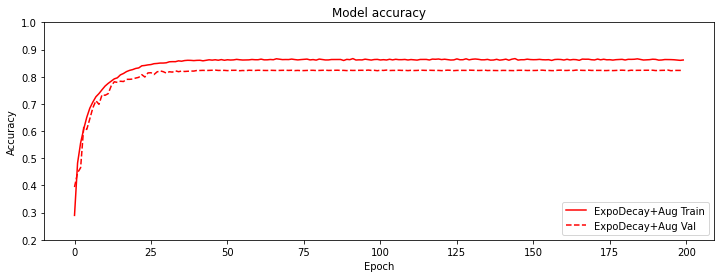

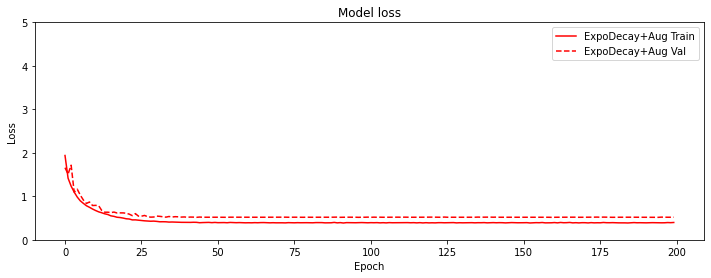

In [0]:
# Test set accuracy
_, lr_aug_test_acc = lr_aug_model.evaluate(x_test, y_test, verbose = 0)
print("ExpoDecay+Aug test accuracy: {}".format(lr_aug_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(lr_aug_history.history['categorical_accuracy'],'r', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_categorical_accuracy'],'r--', label = 'ExpoDecay+Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.2,1)
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(lr_aug_history.history['loss'], 'r', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_loss'], 'r--', label = 'ExpoDecay+Aug Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,5)
plt.legend()
plt.show()

In [0]:
%%time
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.96)

lr_aug_model = Model(inputs=visible, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

metrics = ['categorical_accuracy']

lr_aug_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
lr_aug_history = lr_aug_model.fit(aug_train_batches, epochs = 200, steps_per_epoch = 750,
                                   validation_data=(x_valid, y_valid))

Epoch 1/200
750/750 [==============================] - 62s 83ms/step - loss: 1.8185 - categorical_accuracy: 0.3333 - val_loss: 1.6762 - val_categorical_accuracy: 0.3814
Epoch 2/200
750/750 [==============================] - 53s 70ms/step - loss: 1.4273 - categorical_accuracy: 0.4790 - val_loss: 1.7141 - val_categorical_accuracy: 0.4196
Epoch 3/200
750/750 [==============================] - 53s 70ms/step - loss: 1.2639 - categorical_accuracy: 0.5444 - val_loss: 1.2838 - val_categorical_accuracy: 0.5424
Epoch 4/200
750/750 [==============================] - 53s 70ms/step - loss: 1.1237 - categorical_accuracy: 0.5997 - val_loss: 1.1773 - val_categorical_accuracy: 0.5864
Epoch 5/200
750/750 [==============================] - 53s 71ms/step - loss: 1.0325 - categorical_accuracy: 0.6346 - val_loss: 1.3798 - val_categorical_accuracy: 0.5653
Epoch 6/200
750/750 [==============================] - 53s 70ms/step - loss: 0.9440 - categorical_accuracy: 0.6671 - val_loss: 0.9382 - val_categorical_acc

ExpoDecay+Aug test accuracy: 0.8131999969482422


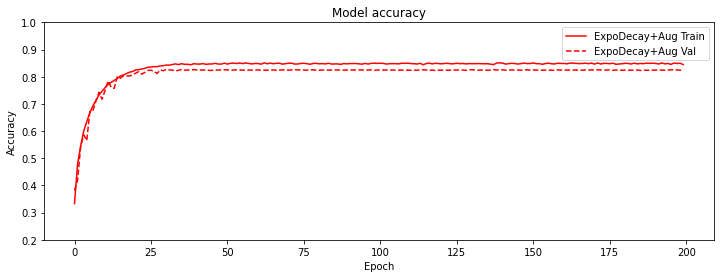

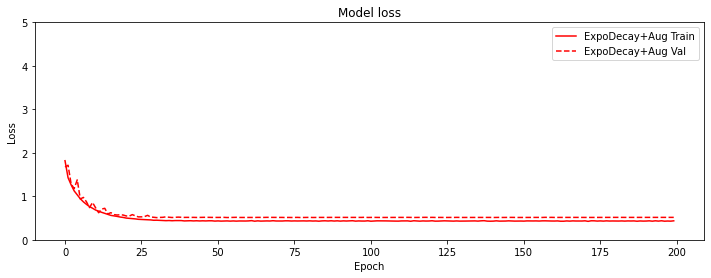

In [0]:
# Test set accuracy
_, lr_aug_test_acc = lr_aug_model.evaluate(x_test, y_test, verbose = 0)
print("ExpoDecay+Aug test accuracy: {}".format(lr_aug_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(lr_aug_history.history['categorical_accuracy'],'r', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_categorical_accuracy'],'r--', label = 'ExpoDecay+Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.2,1)
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(lr_aug_history.history['loss'], 'r', label = 'ExpoDecay+Aug Train')
plt.plot(lr_aug_history.history['val_loss'], 'r--', label = 'ExpoDecay+Aug Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,5)
plt.legend()
plt.show()

---
##**REFERENCE**

Brownie, J 2019, How to Develop VGG, Inception and ResNet Modules from Scratch in Keras, <https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/>.

He, K, Zhang, X, Ren, S & Sun, J 2016, 'Deep Residual Learning for Image Recognition', in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), pp. 770-8.

Keras 2020, Keras Applications, <https://keras.io/api/applications/>.

Liu, S & Deng, W 2015, 'Very deep convolutional neural network based image classification using small training sample size', in 2015 3rd IAPR Asian Conference on Pattern Recognition (ACPR), pp. 730-4.


---
**END OF ASSIGNMENT TWO**